In [1]:
# IMPORTS
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input,optimizers, Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers, Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import applications
from tensorflow.keras.callbacks import ModelCheckpoint
from collections import namedtuple
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime, time
import os, sys
import tqdm
import gc
from keras import callbacks
from multiprocessing import Process
Point = namedtuple('Point', ('x', 'y'))
Circle = namedtuple('Circle', ('r'))
Square = namedtuple('Square', ('side'))
Rectangle = namedtuple('Rectangle', ('length', 'width'))
PointWithDistance = namedtuple('PointWithDistance', ('p', 'dist'))
float_memory_used = 'float32'

In [2]:
# INIT
# PART 1
number_samples = [128, 256, 512, 1024, 4096] 
validation_size, noise_floor = 0.2, -110.0
su_power = 0 # this is not actually su power just a number to show there is an SU in its image
max_x, max_y, number_image_channels, su_szie = 299, 299, 8, 60  # su_size:30 for 1000, 10 for 100
cell_size, pixel_expansion = 1000 / max_x, max_x / 100
pu_shape, su_shape = 'circle', 'circle' # shape = {'circle', 'square', 'point'}
style = "raw_power_min_max_norm"  # {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
intensity_degradation, slope, su_slope = 'log', 5, 5  # 'log', 'linear', slope 3 for 1000, 5 for 100
max_pus_num, max_sus_num = 20, 1
propagation_model = 'splat' # 'splat', 'log', 'testbed'
noise, std = False, 1 # False for splat
if su_shape == 'circle':
    su_param = Circle(su_szie)
elif su_shape == 'square':
    su_param = Square(su_szie)
else:
    su_param = None
    
sensors = False
if sensors:
    sensors_num = 225
    sensors_file_path = f"data/sensors/square{100}/{sensors_num}/sensors.txt"
# num_pus = (data_reg.shape[1] - 3)//3

# PART 2
number_of_proccessors = 12
memory_size_allowed = 4 # in Gigabyte
float_size = 0
if float_memory_used == "float16":
    float_size = 16
elif float_memory_used == "float" or "float32":
    float_size = 32
elif float_memory_used == "float8":
    float_size = 8


batch_size = int(memory_size_allowed / (max_x * max_y * number_image_channels * float_size/(8 * 1024 ** 3)))


dtime = datetime.datetime.now().strftime('_%Y%m_%d%H_%M')
color = "color" if number_image_channels > 1 else "gray"
image_dir = 'ML/data/pictures_' + str(max_x) + '_' + str(max_y) + '_transfer/' + propagation_model + (
    "/noisy_std_" + str(std) if noise else "") + '/pu_' + pu_shape + '_su_' + su_shape + '_' + (
    "" if su_shape == 'point' else str(su_szie)) + "/" + style + "/" + color +'/' + (
    "" if pu_shape == 'point' and su_shape == 'point' else (f"{intensity_degradation}_pu{slope}_su{su_slope}")) + (
    "/" + str(sensors_num) + "sensors" if sensors else f"/{max_pus_num}pus") + \
        f"_{max_sus_num}sus_{number_image_channels}channels" + "/images"

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

In [3]:
image_dir 

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/images'

In [5]:
# image_dir = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/log/" +\
#             "noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/" +\
#             "variable_sensors_10_20_pus_5_sus_8_channels/images"
sensors_location = {}
for sensor_num in [49, 100, 225, 400, 625]:
    sensors_location[sensor_num] = []
    with open(f"data/sensors/square{100}/{sensor_num}/sensors.txt", 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location[sensor_num].append(Point(int(float(line[0])), int(float(line[1]))))

In [ ]:
plt.hist(data_reg[0:100:1, :100], bins='auto')

In [3]:
# LOAD DATA
MAX_SU_TOTAL = False
num_columns = (sensors_num + 1 if sensors else max_pus_num * 3 + 1) + max_sus_num * 3 + 2
# num_columns = max_pus_num * 3 + 1 + max_sus_num * 3 + 2
cols = [i for i in range(num_columns)]
dataset_name = "dynamic_pus_using_pus_70000_min10_max20PUs_1SUs_square100grid_splat_2021_10_16_04_46.txt"
max_dataset_name = "dynamic_pus_max_power_70000_min10_max20PUs_1SUs_square100grid_splat_2021_10_16_04_46.txt"
if MAX_SU_TOTAL:
    max_su_total_dataset_name = "dynamic_pus_maximum_total_sus50000_min10_max20PUs_5SUs_square100grid_splat_2022_06_09_13_24.txt"
with open('/'.join(image_dir.split('/')[:-1]) + '/datasets' + dtime + '.txt', 'w') as set_file:
    set_file.write(dataset_name + "\n")
    set_file.write(max_dataset_name)
    if MAX_SU_TOTAL:
        set_file.write(max_su_total_dataset_name)

dataframe = pd.read_csv('data/' 
                        + dataset_name, delimiter=',', header=None, names=cols)
dataframe_max = pd.read_csv('data/' 
                            + max_dataset_name, delimiter=',', header=None)
if MAX_SU_TOTAL:
    dataframe_max_su_total = pd.read_csv('data/' + max_su_total_dataset_name, delimiter=",", header=None,
                                        names=[i for i in range(max_sus_num * 3 + 1)])

dataframe.reset_index(drop=True, inplace=True)
dataframe_max.reset_index(drop=True, inplace=True)
if MAX_SU_TOTAL:
    dataframe_max_su_total.reset_index(drop=True, inplace=True)
dataframe_max[dataframe_max.shape[1] - 1] = dataframe_max[dataframe_max.shape[1] - 1].astype(float)

dataframe_tot = pd.concat([dataframe, dataframe_max.iloc[:, dataframe_max.columns.values[-1:]]], axis=1,
                        ignore_index=True)

idx = dataframe_tot[dataframe_tot[dataframe_tot.columns[-1]] == -float('inf')].index
dataframe_tot.drop(idx, inplace=True)
if MAX_SU_TOTAL:
    dataframe_max_su_total.drop(idx, inplace=True)

data_reg = dataframe_tot.values
data_reg[data_reg < noise_floor] = noise_floor
if MAX_SU_TOTAL:
    data_max_su_tot = dataframe_max_su_total.values

if False and sensors:
    sensors_location = []
    with open(sensors_file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.split(',')
            sensors_location.append(Point(int(float(line[0])), int(float(line[1]))))
del dataframe, dataframe_tot, dataframe_max

In [27]:
data_reg[56,:]

array([225.   , -87.793, -84.376, -83.528, -81.822, -75.905, -66.582,
       -74.179, -73.021, -69.737, -57.872, -67.844, -70.076, -70.457,
       -73.44 , -77.393, -85.975, -82.953, -74.184, -79.187, -77.676,
       -76.026, -73.896, -73.696, -70.641, -65.995, -68.487, -69.938,
       -69.732, -69.752, -72.175, -86.43 , -83.924, -78.311, -77.882,
       -75.753, -72.736, -69.31 , -72.285, -71.614, -70.488, -65.709,
       -64.755, -64.035, -65.505, -70.898, -87.179, -85.966, -80.402,
       -80.979, -77.596, -72.971, -68.651, -72.127, -71.146, -68.837,
       -67.846, -64.873, -45.862, -66.383, -69.093, -87.078, -85.946,
       -84.992, -80.244, -79.394, -76.972, -76.694, -77.052, -70.44 ,
       -71.027, -68.209, -63.084, -62.659, -67.373, -67.48 , -87.243,
       -87.241, -86.551, -80.209, -78.736, -77.566, -74.604, -74.698,
       -71.771, -70.846, -67.554, -60.771, -60.797, -67.122, -67.29 ,
       -88.056, -84.096, -86.428, -85.156, -83.467, -81.174, -80.467,
       -78.297, -71.

In [ ]:
data_reg = data_reg[:30000][:]

In [8]:
data_reg = data_reg[:40000]

In [6]:
data_reg_train = data_reg[12000][:]

In [4]:
data_reg.shape

(45266, 67)

In [5]:
data_max_su_tot[2]

NameError: name 'data_max_su_tot' is not defined

In [10]:
data_reg[0]

array([ 1.0000e+01,  1.4600e+02,  3.5400e+02, -1.4383e+01,  9.6300e+02,
        8.6400e+02, -1.4000e-02,  8.0200e+02,  4.9700e+02, -7.5190e+00,
        9.8900e+02,  6.7400e+02, -2.8032e+01,  6.5600e+02,  7.4500e+02,
       -1.7498e+01,  7.1700e+02,  5.5000e+01, -7.9590e+00,  6.0000e+01,
        4.6600e+02, -2.6270e+01,  9.0800e+02,  2.4400e+02, -1.3175e+01,
        2.6900e+02,  9.2700e+02, -1.8063e+01,  9.7200e+02,  4.6100e+02,
       -2.7130e+01,  1.0000e+00,  8.3800e+02,  8.3000e+01, -1.1468e+01,
        1.0000e+00,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      

In [ ]:
np.max(data_reg[:, -1])

In [5]:
def euclidian_distance(p1: Point, p2: Point):
    return ((p1.x - p2.x) ** 2 + (p1.y - p2.y) ** 2) ** 0.5 * cell_size

def calculate_mu_sigma(data, num_pus):
    sum_non_noise = 0
    for pu_n in range(num_pus): # calculate mu
        sum_non_noise += data[pu_n*3+2]
    mu = ((max_x * max_y - num_pus) * noise_floor + sum_non_noise)/(max_x * max_y)
    sum_square = 0
    for pu_n in range(num_pus): # calculate sigma
        sum_square += (data[pu_n*3+2]-mu)**2
    sum_square += (max_x * max_y - num_pus) * (noise_floor - mu)**2
    sigma = math.sqrt(sum_square/(max_x * max_y))
    return mu, sigma

def get_pu_param(pu_shape: str, intensity_degradation: str, pu_p: float, noise_floor: float, slope: float):
    pu_param = None
    if pu_shape == 'circle':
        if intensity_degradation == "linear":
            pu_param = Circle(int((pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Circle(int(10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'square':
        if intensity_degradation == "linear":
            pu_param = Square(int(2 ** 0.5 * (pu_p - noise_floor) / slope)) # linear
        elif intensity_degradation == "log":
            pu_param = Square(int(2 ** 0.5 * 10 ** ((pu_p - noise_floor) / (10 *slope)))) # log_based
    elif pu_shape == 'point':
        pu_param = None
    else:
        raise ValueError("Unsupported PU shape(create_image)! ", pu_shape)
    return pu_param

def create_image(data, slope, sensors_num, style="raw_power_z_score", noise_floor=-90, pu_shape= 'circle',
                 pu_param=None, su_shape='circle', su_param=None, intensity_degradation="log", 
                 max_pu_power: float=0, max_su_power: float=0):  
    # style = {"raw_power_zscore_norm", "image_intensity", "raw_power_min_max_norm"}
    # intensity_degradation= {"log", "linear"}
    # if param is None, it's automatically calculated. Highest brightness(or power value) (255 or 1.) would
    # assigned to the center(PU location) and radius(side) would be calculated based on its power, slope, and noise floor.
    # If it is given, intensity(power) of pixel beside center would be calculated in the same fashin with an exception that 
    # intensity below zero(noise_floor) would be replaced by zero(noise_floor)
    if style == "raw_power_min_max_norm":
        # In this way, PUs' location are replaced with their power(dBm) and the power would fade with 
        # slope till gets noise_floor(in circle shape)
        
        # creating pu matrix
        image = np.zeros((max_x, max_y, number_image_channels), dtype=float_memory_used)
        if not sensors:
            pus_num = int(data[0])
#             print(pus_num)
            for pu_i in range(pus_num):
                pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
                pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
                pu_p = data[pu_i * 3 + 3]
                pu_channel = int(abs(pu_p)//5) if number_image_channels > 3 else 0
#                 print(pu_x, pu_y, pu_p)
                if pu_param is None:
                    pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
                else:
                    pu_param_p = pu_param
                points = points_inside_shape(center=Point(pu_x, pu_y),
                                             shape=pu_shape, param=pu_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[int(abs(pu_p))//10][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][pu_channel] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][pu_channel] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        else:
            ss_channels_num = number_image_channels - 2
            ss_param, ss_shape = pu_param, pu_shape
            sensors_num = int(data[0])
            sensors_num_at_each_row = int(sensors_num ** 0.5)
            for ss_i in range(sensors_num):
                ss_x = max(0, min(max_x-1, int(sensors_location[sensors_num][ss_i].x * pixel_expansion)))
                ss_y =  max(0, min(max_x-1, int(sensors_location[sensors_num][ss_i].y * pixel_expansion)))
                ss_p = max(noise_floor, data[ss_i+1])
#                 ss_x, ss_y, ss_p = max(0, min(max_x-1, int(sensors_location[ss_i].x * pixel_expansion))), max(
#                     0, min(max_x-1, int(sensors_location[ss_i].y * pixel_expansion))), max(noise_floor, data[ss_i])
#                 ss_channel = 0 
# #                 if -62.5 <= ss_p < -50.0:
# #                     ss_channel = 1
# #                 elif -70.0 <= ss_p < -62.6:
# #                     ss_channel = 2
# #                 elif -77.5 <= ss_p < -70.0:
# #                     ss_channel = 3
# #                 elif -85.0 <= ss_p < -77.5:
# #                     ss_channel = 4
# # #                 elif -70.0 <= ss_p < -65.0:
# # #                     ss_channel = 5
# #                 elif ss_p < -85.0:
# #                     ss_channel = 5
#                 if -70 <= ss_p < -60.0:
#                     ss_channel = 1
#                 elif -80.0 <= ss_p < -70:
#                     ss_channel = 2
#                 elif -90.0 <= ss_p < -80.0:
#                     ss_channel = 3
#                 elif -100.0 <= ss_p < -90.0:
#                     ss_channel = 4
#                 elif ss_p < -100.0:
#                     ss_channel = 5
#                 ss_channel = 0
                ss_row, ss_cols = ss_i // sensors_num_at_each_row, ss_i % sensors_num_at_each_row
                ss_channel = ss_cols % ss_channels_num
                if ss_row % 2:
                    ss_channel = (ss_channel + ss_channels_num // 2) % ss_channels_num
                if ss_param is None:
                    ss_param_p = get_pu_param(ss_shape, intensity_degradation, ss_p, noise_floor, slope)
                else:
                    ss_param_p = ss_param
                points = points_inside_shape(center=Point(ss_x, ss_y), shape=ss_shape, param=ss_param_p)
                for point in points:
                    if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                        if intensity_degradation == "linear":
                            image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * point.dist - noise_floor)/(
                                max_pu_power - noise_floor)
                        elif intensity_degradation == "log":
                            if point.dist < 1:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - noise_floor) / (max_pu_power - noise_floor)
                            else:
                                image[point.p.x][point.p.y][ss_channel] += (ss_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                    max_pu_power - noise_floor)
        del points
        # creating su matrix
        su_num_idx = sensors_num + 1 if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1] * pixel_expansion)))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2] * pixel_expansion)))
            su_p = data[su_num_idx + su_i * 3 + 3]
#             su_p = su_intensity
            su_param_p = get_pu_param(su_shape, intensity_degradation, su_p, noise_floor, su_slope)
            points = points_inside_shape(center=Point(su_x, su_y),
                                         param=su_param_p, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -2
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - su_slope * point.dist - noise_floor)/(max_su_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_su_power - noise_floor)
                        else:
                            su_val = (su_p - su_slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_su_power - noise_floor)
                    image[point.p.x][point.p.y][su_channel] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1] * pixel_expansion)))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2] * pixel_expansion)))
#         print(su_x, su_y)
#         print(su_shape)
#         print(su_param)
        points = points_inside_shape(center=Point(su_x, su_y),
                                     param=su_param, shape=su_shape)
        su_channel = -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[point.p.x][point.p.y][su_channel] += su_intensity
        del points
        return image
        
#         pu_image = [[(noise_floor - mu)/sigma] * max_y for _ in range(max_x)]
    elif style == "image_intensity":
        # creating PU image
        image = np.zeros((1,number_image_channels,max_x, max_y), dtype=float_memory_used)
        pus_num = int(data[0])
        for pu_i in range(pus_num):
            pu_x = max(0, min(max_x-1, int(data[pu_i * 3 + 1] * pixel_expansion))) 
            pu_y = max(0, min(max_x-1, int(data[pu_i * 3 + 2] * pixel_expansion)))
            pu_p = data[pu_i * 3 + 3]
            
            if pu_param is None:
                pu_param_p = get_pu_param(pu_shape, intensity_degradation, pu_p, noise_floor, slope)
            else:
                pu_param_p = pu_param
            
            points = points_inside_shape(center=Point(pu_x, pu_y), shape=pu_shape, param=pu_param_p)
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                        image[0][0][point.p.x][point.p.y] += (pu_p - slope * point.dist - noise_floor)/(
                            max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - noise_floor) / (max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        else:
#                             image[0][0][point.p.x][point.p.y] += (pu_p - slope * 10*math.log10(point.dist) - noise_floor)/(
#                                 max_pu_power - noise_floor)
                            image[0][0][point.p.x][point.p.y] += 0.1
                        
        # creating SU image
        del points
        # creating su matrix
        su_num_idx = sensors_num if sensors else (pus_num * 3 + 1)
        su_num = int(data[su_num_idx])
#         print(su_num)
#         su_num = (len(data) - pus_num * (3 if not sensors else 1)) // 2
#         if not (len(data) - pus_num * (3 if not sensors else 1)) % 2:
#             raise ValueError("Data provided is not correct; can't get SUs' information(create_image)")
        if su_param is None:
            # if su_param is unavailable, a circle(square) with radius(side) 1 is created
            if su_shape == 'circle':
                su_param = Circle(1)
            elif su_shape == 'square':
                su_param = Square(1)
            elif su_shape == 'point':
                su_param = None
            else:
                raise ValueError("Unsupported SU shape(create_image)! ", su_shape)
        
        for su_i in range(su_num - 1):
            su_x = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 1])))
            su_y = max(0, min(max_x-1, int(data[su_num_idx + su_i * 3 + 2])))
            su_p = data[su_num_idx + su_i * 3 + 3]
            
#             su_p = su_intensity
            points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
            su_channel = 0 if number_image_channels == 1 else -1
            for point in points:
                if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                    if intensity_degradation == "linear":
                            su_val = (su_p - slope * point.dist - noise_floor)/(max_pu_power - noise_floor)
                    elif intensity_degradation == "log":
                        if point.dist < 1:
                            su_val = (su_p - noise_floor) / (max_pu_power - noise_floor)
                        else:
                            su_val = (su_p - slope * 10*math.log10(point.dist) - noise_floor)/(
                                max_pu_power - noise_floor)
                    image[0][su_channel][point.p.x][point.p.y] += su_val
            del points
        # the last and  target SU
        su_intensity = 1.
        su_x = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 1])))
        su_y = max(0, min(max_x-1, int(data[su_num_idx + (su_num - 1) * 3 + 2])))
#         print(su_x, su_y)
        points = points_inside_shape(center=Point(su_x, su_y), param=su_param, shape=su_shape)
        su_channel = 0 if number_image_channels == 1 else -1
        for point in points:
            if 0 <= point.p.x < max_x and 0 <= point.p.y < max_y: # TODO should pass image size
                image[0][su_channel][point.p.x][point.p.y] += su_intensity
        del points
        return image       
            
    else:
        raise ValueError("Unsupported style(create_image)! ", style)
        
def points_inside_shape(center: Point, shape: str, param)-> list:
    # This function returns points+distance around center with defined shape
    if shape == 'circle':
        # First creates points inside a square(around orgigin) with 2*r side and then remove those with distance > r.
        # Shift all remaining around center. O(4r^2)
        r, origin = param.r, Point(0, 0)
        square_points = set((Point(x, y) for x in range(max(-int(r/cell_size), -max_x), 
                             min(int(r/cell_size), max_x) + 1) 
                             for y in range(max(-int(r/cell_size), -max_y), min(int(r/cell_size), max_y) + 1)))
        points = []
        while square_points:
            p = square_points.pop()
            dist = euclidian_distance(p, origin)
            if dist <= r:
                points.append(PointWithDistance(Point(p.x + center.x, p.y + center.y), dist))
                if p.x != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, p.y + center.y), dist))
                    square_points.remove(Point(-p.x, p.y))
                if p.y != 0:
                    points.append(PointWithDistance(Point(p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(p.x, -p.y))
                if p.x != 0 and p.y != 0:
                    points.append(PointWithDistance(Point(-p.x + center.x, -p.y + center.y), dist))
                    square_points.remove(Point(-p.x, -p.y))
        del square_points
        return points
    elif shape == 'square':
        half_side = param.side // 2
        return [PointWithDistance(Point(x, y), euclidian_distance(Point(x, y), center)) for x in range(-half_side + center.x,
                                                                                               half_side + center.x+1) 
                         for y in range(-half_side + center.y, half_side + center.y + 1)]
    elif shape == 'point':
        return [PointWithDistance(center, 0)]
    else:
        raise ValueError("Unsupported shape(points_inside_shape)! ", shape)
        
def read_image(image_num, image_dir=image_dir):
    if False and style == "image_intensity":
        image = plt.imread(image_dir + '/image' + str(image_num)+'.png')
        image = np.swapaxes(image, 0, 2)
        image = np.array(image[:number_image_channels], dtype=float_memory_used).reshape(1, number_image_channels, max_x, max_y)
    elif  style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        suffix = 'npz'  # npy, npz
#         image = np.load(f"{image_dir}/images{image_num//100000}/image{image_num}.{suffix}") 
        image = np.load(f"{image_dir}/image{image_num}.{suffix}") 
        if type(image) == np.lib.npyio.NpzFile:
            image = image['a']
    
    return image

In [6]:
train_size = 2048
data_reg_train = np.repeat(data_reg[:train_size], 4, axis=0)
image_state = ["", "rot", "lr", "ud"] * train_size
p = np.random.permutation(train_size*4)
data_reg_train = data_reg_train[p]
new_image_state = []
for idx in range(train_size*4):
    new_image_state.append(image_state[p[idx]])

In [7]:
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg_train[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -60)
        if new_image_state[image_num] == "rot":
            image = np.rot90(image, 2)
        elif new_image_state[image_num] == "lr":
            image = np.fliplr(image)
        elif new_image_state[image_num] == "ud":
            image = np.flipud(image)
        np.savez_compressed(image_dir + '/aug/image' + str(image_num), a=np.expand_dims(image,0 ))
        
        del image

In [8]:
jobs = []
proc_sizes = [data_reg_train.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg_train.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|█████████████████████████████████████████| 682/682 [04:09<00:00,  2.73it/s]


In [16]:
# Saving images once to save time
# run this cell just for creating images
def creating_image(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for image_num in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        image = create_image(data=data_reg[image_num], slope=slope, style=style, 
                             noise_floor=noise_floor,
                             pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                             sensors_num=(sensors_num if sensors else 0), 
                             intensity_degradation=intensity_degradation, 
                             max_pu_power=0.0 if not sensors else -60,
                             max_su_power=40.0)
        if False and style == "image_intensity":
            if number_image_channels != 3:
                image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                               dtype=float_memory_used), axis=0)
            image_save = np.swapaxes(image, 0, 2)
            plt.imsave(image_dir + '/image' + str(image_num)+'.png', image_save)
        elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
    #         np.save(image_dir + '/image' + str(image_num), image)
#             np.savez_compressed(f"{image_dir}{(600000 + image_num)//100000}/image{600000 + image_num}",
#                                 a=np.expand_dims(image,0))
            np.savez_compressed(f"{image_dir}/images{image_num//100000}/image{image_num}",
                                a=np.expand_dims(image,0))
        del image

In [18]:
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

  0%|                                      | 3/62576 [00:14<84:08:12,  4.84s/it]




Process Process-12:

Process Process-2:
Process Process-4:
Process Process-6:
Process Process-11:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/shahrokh/miniconda3/envs/research/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/shahrokh/miniconda3/envs/research/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/shahrokh/miniconda3/envs/research/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/shahrokh/miniconda3/envs/research/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/shahrokh/miniconda3/envs/research/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwa

KeyboardInterrupt: 

  0%|                                     | 2/62576 [00:14<126:06:01,  7.25s/it]
Process Process-7:
Traceback (most recent call last):
  File "/home/shahrokh/miniconda3/envs/research/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/shahrokh/miniconda3/envs/research/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/tmp/ipykernel_525258/3108484537.py", line 7, in creating_image
    image = create_image(data=data_reg[image_num], slope=slope, style=style,
  File "/tmp/ipykernel_525258/1963260414.py", line 62, in create_image
    points = points_inside_shape(center=Point(pu_x, pu_y),
  File "/tmp/ipykernel_525258/1963260414.py", line 278, in points_inside_shape
    square_points = set((Point(x, y) for x in range(max(-int(r/cell_size), -max_x),
  File "/tmp/ipykernel_525258/1963260414.py", line 278, in <genexpr>
    square_points = set((Point(x, y) for x in range(max(-int(r/cell_si

In [8]:
sensors_location[225][225]

NameError: name 'sensors_location' is not defined

In [51]:
data_reg[0,:]

array([ 49.   , -67.973, -50.789, -72.345, -72.867, -60.808, -68.141,
       -73.054, -65.912, -66.931, -81.242, -78.197, -68.693, -68.276,
       -75.171, -76.76 , -68.616, -79.3  , -76.408, -70.583, -66.942,
       -68.405, -74.092, -75.976, -75.671, -76.973, -78.145, -68.874,
       -67.967, -74.006, -71.048, -81.523, -77.934, -76.878, -76.477,
       -78.388, -55.4  , -73.306, -76.155, -82.771, -78.345, -84.242,
       -85.043, -68.135, -85.481, -85.117, -79.689, -85.389, -88.734,
       -89.126,   1.   ,  27.   ,  52.   ,  35.852,   0.   ,  22.075])

In [21]:
image_dir

'/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/variable_sensors_10_20_pus_5_sus_8_channels/images'

In [37]:
imm = read_image(1)
new_imm = np.zeros((max_x, max_y), dtype=float_memory_used)
for x in range(max_x):
    for y in range(max_y):
        new_imm[x][y] = imm[0][x][y][-1]

In [56]:
np.max(data_reg[:,-1])

39.059

In [13]:
imm = read_image(0, image_dir=f"{image_dir}")#, image_dir="/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/images")
immm = np.zeros((max_x, max_y, number_image_channels), dtype='float')
for x in range(max_x):
    for y in range(max_y):
        for ch in range(number_image_channels):
            immm[x][y][ch] = float(imm[0][x][y][ch])

In [ ]:
immm[immm>1] = 1.0
plt.imshow(immm)

In [ ]:
## immm[immm>1] = 1.0
plt.imshow(immm)

In [ ]:
data_reg[123853,:]

In [ ]:
rotated_im = np.rot90(immm, 2)

In [ ]:

img_rot = ndimage.rotate(immm, -90, reshape=False)
img_rot = np.rot90(immm,2)
plt.imshow(img_rot)


In [14]:
data_reg[0]

array([ 19.   ,  38.   ,  65.   , -19.658,  69.   ,  49.   ,  -7.351,
        88.   ,  42.   ,  -6.322,  28.   ,  17.   ,  -5.694,  61.   ,
        45.   , -17.43 ,   2.   ,  55.   , -24.392,  57.   ,  95.   ,
       -20.778,  52.   ,  79.   , -21.744,  52.   ,   5.   , -13.93 ,
         6.   ,  39.   ,  -6.269,  87.   ,   8.   , -21.177,  26.   ,
        80.   , -20.406,  19.   ,  63.   , -15.858,  30.   ,  19.   ,
       -13.793,  27.   ,  50.   , -17.062,  95.   ,  95.   , -29.368,
        39.   ,  71.   ,  -3.309,  52.   ,  59.   , -11.98 ,  38.   ,
        16.   , -22.553,   1.   ,  95.   ,  30.   ,  -7.839,   1.   ,
           nan,     nan,     nan,  11.077])

In [38]:
sensors_location[49]

NameError: name 'sensors_location' is not defined

<AxesSubplot:>

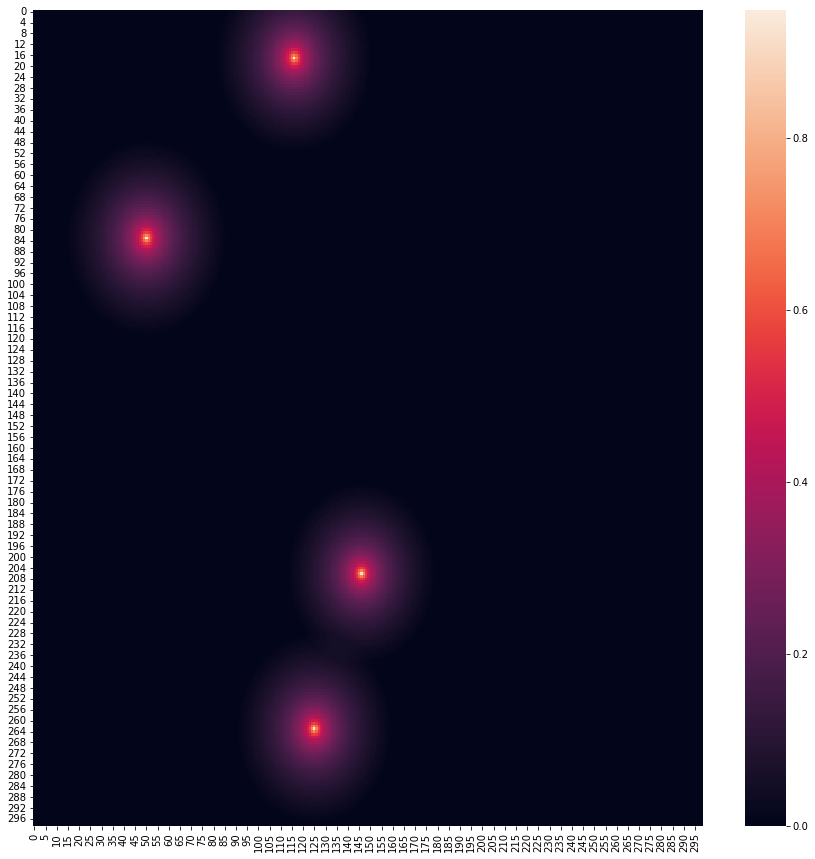

In [18]:

fig, ax = plt.subplots(figsize=(15,15))         # Sample figsize in inches
sns.heatmap(imm[0,:,:,1], ax=ax)

In [9]:
def cnn_model(kernel_lam, bias_lam):
    inputs = Input(shape=(max_x, max_y, number_image_channels))
    convolution_filter, dense_filter = 'relu', 'linear'
    convolution_init, dense_init = "lecun_normal", "RandomNormal"
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
#     base_model.trainable = False
    cnn = base_model(inputs, training=False)
#     cnn = base_model(inputs)
    
#     cnn = layers.Dense(1024, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
#                              bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
#     cnn = layers.Dropout(0.5)(cnn)
    if True:
        # Convert features of shape `base_model.output_shape[1:]` to vectors
        cnn = layers.GlobalAveragePooling2D()(cnn)
        cnn = layers.Dense(2048, activation=convolution_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=convolution_init)(cnn)
        cnn = layers.Dropout(0.5)(cnn)
        outputs = layers.Dense(1, activation=dense_filter, kernel_regularizer=regularizers.l2(kernel_lam),
                             bias_regularizer=regularizers.l2(bias_lam), kernel_initializer=dense_init)(cnn)
        return Model(inputs, outputs)
    else:
        data_format="channels_last"
        filter_shape, pool_size = (1, 1), (2,2)
        cnn = layers.Conv2D(512, filter_shape, padding='same', 
                            activation=convolution_filter, data_format=data_format, 
                            kernel_regularizer=regularizers.l2(kernel_lam), 
                            bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.MaxPooling2D(pool_size=pool_size, data_format=data_format)(cnn)
        cnn = layers.Conv2D(512, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(128, filter_shape,padding='same', activation=convolution_filter,
                            data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(32, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(8, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.Conv2D(1, filter_shape,padding='same', activation=convolution_filter, data_format=data_format, 
                         kernel_regularizer=regularizers.l2(kernel_lam), bias_regularizer=regularizers.l2(bias_lam),
                         kernel_initializer=convolution_init)(cnn)
        cnn = layers.GlobalAveragePooling2D()(cnn)
        return Model(inputs, cnn)
    

class DataBatchGenerator(Sequence):
    def __init__(self, dataset:np.ndarray, batch_size:int, start_idx:int,
                 number_image_channels:int,
                 max_x, max_y, float_memory_used, image_dir = image_dir, conserve=0):
#         print(dataset.shape[0])
#         print("generator initiated")
        self.dataset, self.batch_size, self.start_idx = dataset, batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.conserve = conserve
        self._image_dir = image_dir
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
#         print('generator yielded a batch %d' % idx)
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.max_x, self.max_y, self.number_image_channels), 
                           dtype=self.float_memory_used)
        batch_y = np.empty((size), dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i, self._image_dir)
            batch_y[i] = self.dataset[idx * self.batch_size + i][- 1 - self.conserve]
        return batch_x, batch_y

class PredictBatchGenerator(Sequence):
    def __init__(self, dataset_size: int, batch_size: int, start_idx: int,
                 number_image_channels: int, max_x: int,
                 max_y: int, float_memory_used,
                 image_dir: str):
        self.dataset_size = dataset_size
        self.batch_size, self.start_idx = batch_size, start_idx
        self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.image_dir = image_dir
    
    def __len__(self):
        return np.ceil(self.dataset_size / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
        size = min(self.dataset_size - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.max_x, self.max_y, self.number_image_channels),
                           dtype=self.float_memory_used)
        for i in range(size):
            batch_x[i] = read_image(self.start_idx + idx * self.batch_size + i, self.image_dir)
        return batch_x
        
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)


In [41]:
# Xception model
model_name = "ResNet50V2"
base_model = applications.ResNet50V2(include_top=False, weights=None,
                                      input_shape=(max_x, max_y, number_image_channels))
base_model.trainable = True
base_model.summary()

/home/shahrokh/miniconda3/envs/research/lib/python3.9/site-packages/keras/applications/imagenet_utils.py:331: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 8 input channels.
  warnings.warn('This model usually expects 1 or 3 input channels. '
2022-06-17 12:23:15.696952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 12:23:15.749319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 12:23:15.750764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-17 12:23:15.753517: I tensorf

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 8) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 8)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 25152       conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [12]:
# log-vgg pretrained - pu-setting
model_name = "log_vgg16"
fp_penalty_coef, fn_penalty_coef = 1, 1
model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/log/noisy_std_1/" + \
             "pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/20pus_5sus_8channels/models/vgg16/" + \
             "700000/best_model_lambda_0.1.h5"
model_path = "ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/" + \
             "raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels_700k/models/700000/" + \
             "best_model_lambda_0_fit.h5"
base_model = models.load_model(model_path, 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
base_model.trainable = False
base_model = base_model.layers[1]
base_model.summary()

2022-06-09 17:53:49.712847: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 17:53:49.718095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 17:53:49.718537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-09 17:53:49.719328: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [10]:
# log-vgg pretrained - ss-setting
model_name = "ResNet50V2"
fp_penalty_coef, fn_penalty_coef = 1, 1
model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/" +\
             "pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/" + \
             "raw_power_min_max_norm/color/log_pu5_su6/" + \
             "variable_sensors_10_20_pus_5_sus_8_channels/models/ResNet152V2/" + \
             "700000/best_model_lambda_0_1.h5"
model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/" +\
             "log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su6/"+\
             "20pus_5sus_8channels/models/ResNet50V2/700000/best_model_lambda_0_lr0.01_mae10.725.h5"
base_model = models.load_model(model_path, 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
base_model = base_model.layers[1]
base_model.trainable = False
base_model.summary()

2022-06-20 18:21:16.663937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 18:21:16.698809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 18:21:16.699244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 18:21:16.701631: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 8) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 8)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 25152       conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 152, 152, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [ ]:
from vit_keras import vit, utils
model_name = "vit_l16"
def transformer_model():
    model = vit.vit_l16(image_size=max_x, activation='linear',
                        pretrained=True, include_top=True, pretrained_top=False, classes=1)
    for l_index in range(len(model.layers) - 1):
        model.layers[l_index].trainable = False
    return model

In [ ]:
mod = transformer_model()

In [26]:
cnn1.layers[2].trainable

True

In [22]:
cnn1 = cnn_model(0, 0)

In [24]:
cnn1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 8)]     0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 10, 10, 2048)      23580480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 27,778,881
Trainable params: 4,198,401
Non-trainable params: 23,580,480
_________________________________________

In [11]:
# tf.test.is_gpu_available()
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [12]:
number_samples = [2048]

In [13]:
number_samples 

[2048]

In [50]:
number_samples = [700000]

In [16]:
# CNN: support batching
AUGMENTED = True
TEST, CONSERVE, FINE_TUNING = True, False, True
mini_batch = 32 if max(max_x, max_y) == 1000 else 64
epochs = 35 if max(max_x, max_y) == 1000 else 130
MAX_QUEUE_SIZE, WORKERS = 28, 4
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_mae", 'min'  # the metric that hyper parameters are tuned with
prev_sample = 0
lambda_vec = [0, 0.01, 0.1, 1] 
# average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
# best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
all_cnns = []
if CONSERVE: # for conservative
    prev_number_samples = [0] + number_samples[:-1]

for num_sample_idx, number_sample in enumerate(number_samples):
    if CONSERVE:
        data_reg[prev_number_samples[num_sample_idx]:number_sample, -1] = data_reg[
            prev_number_samples[num_sample_idx]:number_sample, -1] - 1.5 # conserv value
    MODEL_PATH = '/'.join(image_dir.split('/')[:-1]) + '/models/' + ("aug/" if AUGMENTED else "") \
    + model_name + "/" + ("conservative/" if CONSERVE else "") + str(number_sample)
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        cnns = [cnn_model(lamb, 0) for lamb in lambda_vec]
#         cnns = [models.load_model(MODEL_PATH  + '0.h5', 
#                                   custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
#                                                    'fp_mae': fp_mae,
#                                                    'mae':'mae', 'mse':'mse'})]
        for cnn in cnns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            # =optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1/epochs, nesterov=False)
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', fp_mae])
#             cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
#                         optimizer=optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9,
#                                                 nesterov=True, clipnorm=1.0), 
#                         metrics=['mse', 'mae', fp_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb)+ '.h5',
                                         verbose=2, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb in lambda_vec]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb in lambda_vec]
    number_start = time.time()
    train_generator = DataBatchGenerator(
        dataset=data_reg_train[:number_sample * 4] if AUGMENTED else data_reg[:number_sample],
        batch_size=mini_batch,
        start_idx=prev_sample,
        number_image_channels=number_image_channels,
        max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
        image_dir=image_dir + ("/aug" if AUGMENTED else ""))
    

    val_size = math.ceil(number_sample * validation_size)
#     val_size = data_reg.shape[0] - number_sample
    val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        cnns[lamb_idx].fit(train_generator, epochs=epochs, verbose=2,
                           validation_data=val_generator, 
                           shuffle=True, callbacks=[checkpointers[lamb_idx], 
                                                    callbacks.EarlyStopping(monitor=hyper_metric, min_delta=1e-2,
                                                                           patience=10,
                                                                           mode=mode)],
#                                                    callbacks.ReduceLROnPlateau(monitor=hyper_metric,
#                                                                               factor=0.2,
#                                                                               patience=10,
#                                                                               mode=mode)], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
        print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
        print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
              [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    if FINE_TUNING:
    # ******************** fine-tunning *******
        print("******FINE TUNNING ******")
        # reloading the best
        cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                   'fp_mae': fp_mae,
                                                   'mae':'mae', 'mse':'mse'}) for lamb in lambda_vec]
        for cnn in cnns:
            cnn.trainable = True
            cnn.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(1e-5), 
                        metrics=['mse', 'mae', fp_mae])
        train_generator = DataBatchGenerator(
            dataset=data_reg_train[:number_sample * 4] if AUGMENTED else data_reg[:number_sample],
            batch_size=mini_batch//2,
            start_idx=prev_sample,
            number_image_channels=number_image_channels,
            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
            image_dir=image_dir + ("/aug" if AUGMENTED else ""))
        val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                           batch_size=mini_batch,
                                           start_idx=number_sample,
                                           number_image_channels=number_image_channels,
                                           max_x=max_x, max_y=max_y, 
                                           float_memory_used=float_memory_used,
                                          image_dir="/".join(image_dir.split("/")[:-1]) + "/images")
        for lamb_idx, lamb in enumerate(lambda_vec):
    #     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
    #         if num_sample_idx == 3 and lamb_idx < 4:
    #             continue
            lambda_start = time.time()
            cnns[lamb_idx].fit(train_generator, epochs=int(epochs//2), verbose=2,
                               validation_data=val_generator, 
                               shuffle=True, callbacks=[checkpointers[lamb_idx],
                                                        callbacks.EarlyStopping(
                                                            monitor=hyper_metric, min_delta=1e-2,
                                                            patience=7, mode=mode)], 
                               workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                               use_multiprocessing=False)

            print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
            print("Train Error(all epochs):", min(cnns[lamb_idx].history.history['mae']), '\n', 
                  [round(val, 3) for val in cnns[lamb_idx].history.history['mae']])
            print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
                  [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
            print("Val Error(all epochs):", min(cnns[lamb_idx].history.history['val_mae']), '\n', 
                  [round(val,3) for val in cnns[lamb_idx].history.history['val_mae']])
            print("Val FP Error(all epochs):", min(cnns[lamb_idx].history.history['val_fp_mae']), '\n',
                  [round(val,3) for val in cnns[lamb_idx].history.history['val_fp_mae']])
    
    models_min_mae = [min(cnns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(cnns)
    del cnns, train_generator, val_generator
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(lambda_vec[best_lamb_idx]) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
        test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                            batch_size=mini_batch * 2,
                                            start_idx=number_sample + val_size, 
                                            number_image_channels=number_image_channels,
                                            max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
        test_res = best_model.evaluate(test_generator, verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
        test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
                                         for mtrc in ['mae','fp_mae']]
        test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
        average_diff_power.append(round(test_mae, 3))
        fp_mean_power.append(round(test_fp_mae, 3))
        print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
              fp_mean_power[-1])
        
        if False:
            test_generator_conserve = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                                         batch_size=mini_batch,
                                                         start_idx=number_sample + val_size, 
                                                         number_image_channels=number_image_channels,
                                                         max_x=max_x, max_y=max_y, 
                                                         float_memory_used=float_memory_used, 
                                                         conserve=1)
            test_res_conserve = best_model.evaluate(test_generator_conserve, verbose=1, 
                                                    workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                                                    use_multiprocessing=False)
            test_mae_cons, test_fp_mae_cons = test_res_conserve[test_mae_idx], test_res_conserve[test_fp_mae_idx]
            average_diff_power_conserve.append(round(test_mae_cons, 3))
            fp_mean_power_conserve.append(round(test_fp_mae_cons, 3))
            print('Conserve, average_error: ', average_diff_power_conserve[-1], ', fp_average_error: ',
                 fp_mean_power_conserve[-1])
        print("\n\n")

        
#         var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/models/' + model_name + "/"
#                      + intensity_degradation + '_' + str(slope) + '_' + 
#                      dtime + ".dat", "wb") # file for saving results
#         pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
#                      dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve,
#                      checkpointers],
#                     file=var_f)
#         var_f.close()
        del best_model, test_generator
#     prev_sample = number_sample

number_samples: 2048 , New samples: 2048
Validation size: 410 , starts: 2048 , ends: 2457


2022-06-20 18:21:44.459481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/130


2022-06-20 18:21:47.976063: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-06-20 18:21:50.676865: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


128/128 - 35s - loss: 32.8358 - mse: 32.8358 - mae: 4.2681 - fp_mae: 1.9145 - val_loss: 21.7690 - val_mse: 21.7690 - val_mae: 3.5315 - val_fp_mae: 1.4968

Epoch 00001: val_mae improved from inf to 3.53150, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.h5


/home/shahrokh/miniconda3/envs/research/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/130
128/128 - 29s - loss: 22.8357 - mse: 22.8357 - mae: 3.6185 - fp_mae: 1.7877 - val_loss: 20.3760 - val_mse: 20.3760 - val_mae: 3.4190 - val_fp_mae: 1.4539

Epoch 00002: val_mae improved from 3.53150 to 3.41904, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.h5
Epoch 3/130
128/128 - 29s - loss: 22.0885 - mse: 22.0885 - mae: 3.5507 - fp_mae: 1.7669 - val_loss: 19.8542 - val_mse: 19.8542 - val_mae: 3.3893 - val_fp_mae: 1.3726

Epoch 00003: val_mae improved from 3.41904 to 3.38926, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.h5
Epoch 4/130
128/128 - 29s - loss: 21.7513 - mse: 21.7513 - mae: 3.5146 - fp_mae: 1.7428 - val_loss: 19.2726 - val_mse: 19.2726 - val_mae: 3.3143 - val_fp_mae: 1.5189

Epoch 0

Epoch 30/130
128/128 - 29s - loss: 19.7297 - mse: 19.7297 - mae: 3.3340 - fp_mae: 1.6678 - val_loss: 18.5389 - val_mse: 18.5389 - val_mae: 3.2148 - val_fp_mae: 1.8153

Epoch 00030: val_mae improved from 3.23256 to 3.21481, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.h5
Epoch 31/130
128/128 - 29s - loss: 19.8134 - mse: 19.8134 - mae: 3.3467 - fp_mae: 1.6606 - val_loss: 18.7007 - val_mse: 18.7007 - val_mae: 3.2449 - val_fp_mae: 1.7724

Epoch 00031: val_mae did not improve from 3.21481
Epoch 32/130
128/128 - 29s - loss: 19.9072 - mse: 19.9072 - mae: 3.3585 - fp_mae: 1.6635 - val_loss: 18.3934 - val_mse: 18.3934 - val_mae: 3.2200 - val_fp_mae: 1.5523

Epoch 00032: val_mae did not improve from 3.21481
Epoch 33/130
128/128 - 29s - loss: 19.8822 - mse: 19.8822 - mae: 3.3541 - fp_mae: 1.6722 - val_loss: 19.1944 - val_mse: 19.1944 - val_mae: 3.2445 - va


Epoch 00013: val_mae improved from 3.29796 to 3.28922, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.01.h5
Epoch 14/130
128/128 - 29s - loss: 21.9401 - mse: 21.1652 - mae: 3.4543 - fp_mae: 1.7136 - val_loss: 20.4643 - val_mse: 19.7052 - val_mae: 3.3206 - val_fp_mae: 2.0328

Epoch 00014: val_mae did not improve from 3.28922
Epoch 15/130
128/128 - 29s - loss: 22.0833 - mse: 21.3146 - mae: 3.4738 - fp_mae: 1.7207 - val_loss: 20.9107 - val_mse: 20.1520 - val_mae: 3.3557 - val_fp_mae: 2.1362

Epoch 00015: val_mae did not improve from 3.28922
Epoch 16/130
128/128 - 29s - loss: 21.8476 - mse: 21.0849 - mae: 3.4506 - fp_mae: 1.7174 - val_loss: 20.0371 - val_mse: 19.2784 - val_mae: 3.2877 - val_fp_mae: 1.7373

Epoch 00016: val_mae improved from 3.28922 to 3.28767, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_mi

Epoch 10/130
128/128 - 29s - loss: 24.4646 - mse: 22.1480 - mae: 3.5573 - fp_mae: 1.7656 - val_loss: 22.6432 - val_mse: 20.3341 - val_mae: 3.3663 - val_fp_mae: 1.9098

Epoch 00010: val_mae improved from 3.39782 to 3.36629, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.1.h5
Epoch 11/130
128/128 - 28s - loss: 24.4439 - mse: 22.1390 - mae: 3.5658 - fp_mae: 1.7702 - val_loss: 22.8432 - val_mse: 20.5113 - val_mae: 3.3896 - val_fp_mae: 1.8883

Epoch 00011: val_mae did not improve from 3.36629
Epoch 12/130
128/128 - 28s - loss: 24.5922 - mse: 22.2868 - mae: 3.5721 - fp_mae: 1.7718 - val_loss: 22.5366 - val_mse: 20.1987 - val_mae: 3.3708 - val_fp_mae: 1.6861

Epoch 00012: val_mae did not improve from 3.36629
Epoch 13/130
128/128 - 29s - loss: 24.4791 - mse: 22.1655 - mae: 3.5593 - fp_mae: 1.7668 - val_loss: 22.4757 - val_mse: 20.1507 - val_mae: 3.3603 - 

Epoch 10/130
128/128 - 28s - loss: 33.8382 - mse: 25.1292 - mae: 3.8234 - fp_mae: 1.8754 - val_loss: 32.2442 - val_mse: 23.3545 - val_mae: 3.6500 - val_fp_mae: 1.9423

Epoch 00010: val_mae did not improve from 3.64321
Epoch 11/130
128/128 - 28s - loss: 34.0271 - mse: 25.3389 - mae: 3.8470 - fp_mae: 1.8817 - val_loss: 33.1878 - val_mse: 24.6831 - val_mae: 3.7314 - val_fp_mae: 2.4443

Epoch 00011: val_mae did not improve from 3.64321
Epoch 12/130
128/128 - 28s - loss: 34.2161 - mse: 25.6208 - mae: 3.8728 - fp_mae: 1.8976 - val_loss: 32.4883 - val_mse: 23.3173 - val_mae: 3.6991 - val_fp_mae: 1.5215

Epoch 00012: val_mae did not improve from 3.64321
Epoch 13/130
128/128 - 28s - loss: 34.0348 - mse: 25.3710 - mae: 3.8405 - fp_mae: 1.8767 - val_loss: 33.2652 - val_mse: 25.1665 - val_mae: 3.7598 - val_fp_mae: 2.5194

Epoch 00013: val_mae did not improve from 3.64321
Epoch 14/130
128/128 - 29s - loss: 33.9205 - mse: 25.4488 - mae: 3.8485 - fp_mae: 1.8897 - val_loss: 31.7276 - val_mse: 23.5318 


Epoch 00005: val_mae improved from 3.10964 to 3.10897, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.h5
Epoch 6/65
256/256 - 38s - loss: 17.1854 - mse: 17.1854 - mae: 3.0944 - fp_mae: 1.5309 - val_loss: 17.5553 - val_mse: 17.5553 - val_mae: 3.1005 - val_fp_mae: 1.7900

Epoch 00006: val_mae improved from 3.10897 to 3.10055, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.h5
Epoch 7/65
256/256 - 38s - loss: 16.9262 - mse: 16.9262 - mae: 3.0630 - fp_mae: 1.5262 - val_loss: 17.3933 - val_mse: 17.3933 - val_mae: 3.0897 - val_fp_mae: 1.7528

Epoch 00007: val_mae improved from 3.10055 to 3.08972, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/

Epoch 11/65
256/256 - 39s - loss: 18.2169 - mse: 17.5085 - mae: 3.1128 - fp_mae: 1.5388 - val_loss: 17.7291 - val_mse: 17.0221 - val_mae: 3.1084 - val_fp_mae: 1.6202

Epoch 00011: val_mae did not improve from 3.10021
Epoch 12/65
256/256 - 39s - loss: 18.0637 - mse: 17.3579 - mae: 3.0921 - fp_mae: 1.5421 - val_loss: 17.6143 - val_mse: 16.9098 - val_mae: 3.1282 - val_fp_mae: 1.4827

Epoch 00012: val_mae did not improve from 3.10021
Epoch 13/65
256/256 - 39s - loss: 17.8436 - mse: 17.1403 - mae: 3.0776 - fp_mae: 1.5238 - val_loss: 17.5803 - val_mse: 16.8781 - val_mae: 3.1032 - val_fp_mae: 1.5790

Epoch 00013: val_mae did not improve from 3.10021
Epoch 14/65
256/256 - 39s - loss: 17.8085 - mse: 17.1075 - mae: 3.0735 - fp_mae: 1.5245 - val_loss: 17.7566 - val_mse: 17.0568 - val_mae: 3.0864 - val_fp_mae: 1.7153

Epoch 00014: val_mae improved from 3.10021 to 3.08644, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1


Epoch 00009: val_mae improved from 3.14054 to 3.11399, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.1.h5
Epoch 10/65
256/256 - 39s - loss: 20.2262 - mse: 18.1499 - mae: 3.1793 - fp_mae: 1.5703 - val_loss: 19.4562 - val_mse: 17.3871 - val_mae: 3.1244 - val_fp_mae: 1.6344

Epoch 00010: val_mae did not improve from 3.11399
Epoch 11/65
256/256 - 40s - loss: 19.9171 - mse: 17.8541 - mae: 3.1489 - fp_mae: 1.5499 - val_loss: 19.2673 - val_mse: 17.2130 - val_mae: 3.1116 - val_fp_mae: 1.6497

Epoch 00011: val_mae improved from 3.11399 to 3.11156, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_0.1.h5
Epoch 12/65
256/256 - 39s - loss: 19.7449 - mse: 17.6966 - mae: 3.1364 - fp_mae: 1.5629 - val_loss: 19.1439 - val_mse: 

Epoch 1/65
256/256 - 44s - loss: 31.4964 - mse: 23.4213 - mae: 3.6988 - fp_mae: 1.7800 - val_loss: 28.9687 - val_mse: 21.0708 - val_mae: 3.4281 - val_fp_mae: 1.8598

Epoch 00001: val_mae improved from 3.59735 to 3.42815, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_1.h5
Epoch 2/65
256/256 - 38s - loss: 30.0056 - mse: 22.2527 - mae: 3.5819 - fp_mae: 1.7257 - val_loss: 27.8276 - val_mse: 20.2187 - val_mae: 3.3351 - val_fp_mae: 1.8461

Epoch 00002: val_mae improved from 3.42815 to 3.33506, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_1sus_8channels/models/aug/ResNet50V2/2048/best_model_lambda_1.h5
Epoch 3/65
256/256 - 38s - loss: 28.8153 - mse: 21.3238 - mae: 3.4966 - fp_mae: 1.6924 - val_loss: 26.9133 - val_mse: 19.5429 - val_mae: 3.2737 - val_fp_mae: 1.7517

Epoch 0000

Test starts:  2458 , ends:  45265
335/335 [==============================] - 163s 479ms/step - loss: 17.8753 - mse: 15.9876 - mae: 3.0303 - fp_mae: 1.6276
average_error:  3.03 , fp_average_error:  1.628





In [14]:
average_diff_power, fp_mean_power, best_lambda = [3.494, 3.444, 3.224, 3.098], [1.425, 1.427, 1.638, 1.681], [0.1, 0.1, 0.1, 0.01]

In [15]:
print("average_diff_power:", [round(x, 3) for x in average_diff_power])
print("fp_error:", [round(x, 3) for x in fp_mean_power])
print("best_lambda:", best_lambda)

average_diff_power: [3.494, 3.444, 3.224, 3.098]
fp_error: [1.425, 1.427, 1.638, 1.681]
best_lambda: [0.1, 0.1, 0.1, 0.01]


In [67]:
all_cnns[0][0].optimizer.get_config()

{'name': 'SGD',
 'clipnorm': 1.0,
 'learning_rate': 0.01,
 'decay': 1e-06,
 'momentum': 0.9,
 'nesterov': True}

In [31]:
# Saving images once to save time
# run this cell just for creating images
def creating_image_max_su_tot(start, end):
    # for image_num in range(115, data_reg.shape[0]):
    # for image_num in range(1625, 5000):
    for row_idx in tqdm.tqdm(range(start, end+1)):  #4463, data_reg.shape[0]
        row_sample = data_reg[row_idx]
        row_sample[int(row_sample[0]) * 3 + 1] = 1
        for su_idx in range(int(data_max_su_tot[row_idx][0])):
            row_sample[int(row_sample[0]) * 3 + 2 : 
                       int(row_sample[0]) * 3 + 4] = data_max_su_tot[row_idx][1 + su_idx * 3: 
                                                                              1 + su_idx * 3 + 2]
            image = create_image(data=row_sample, 
                                 slope=slope, style=style, noise_floor=noise_floor,
                                 pu_shape=pu_shape, su_shape=su_shape, su_param=su_param, 
                                 sensors_num=(sensors_num if sensors else 0), 
                                 intensity_degradation=intensity_degradation, 
                                 max_pu_power=0.0 if not sensors else -60,
                                 max_su_power=40.0)
            if False and style == "image_intensity":
                if number_image_channels != 3:
                    image = np.append(np.array(image[0]), np.zeros((3-number_image_channels,max_x, max_y), 
                                                                   dtype=float_memory_used), axis=0)
                image_save = np.swapaxes(image, 0, 2)
                plt.imsave(max_su_image_dir + '/image' + str(image_num)+'.png', image_save)
            elif style == "raw_power_min_max_norm" or style == "raw_power_zscore_norm" or style == "image_intensity":
        #         np.save(max_su_image_dir + '/image' + str(image_num), image)
    #             np.savez_compressed(f"{image_dir}{(600000 + image_num)//100000}/image{600000 + image_num}",
    #                                 a=np.expand_dims(image,0))
                np.savez_compressed(f"{max_su_image_dir}/image{row_idx * 5 + su_idx}",
                                    a=np.expand_dims(image,0))
            del image

In [32]:
model_name = "log_vgg16_max_su_total"
max_su_image_dir = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name + "/images"
if not os.path.exists(max_su_image_dir):
        os.makedirs(max_su_image_dir)
jobs = []
proc_sizes = [data_reg.shape[0]//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += data_reg.shape[0]%number_of_proccessors
proc_idx = [(sum(proc_sizes[:i]), sum(proc_sizes[:i+1])-1) for i in range(number_of_proccessors)]

for i in range(number_of_proccessors):
    p = Process(target=creating_image_max_su_tot, args=(proc_idx[i][0], proc_idx[i][1]))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs

100%|█████████████████████████████████████| 2680/2680 [1:07:55<00:00,  1.52s/it]


In [228]:
max_su_image_dir

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/images'

In [85]:
# Multi-SU using single deep-alloc and another NN
# Create dataset

number_samples = [128, 256, 512, 1024, 2048, 4096]
MAX_QUEUE_SIZE, WORKERS = 28, 4
mini_batch = 128
fp_penalty_coef, fn_penalty_coef = 1, 1
dataset_path = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name

model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/" + \
             "splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/" + \
             "pus_1_sus_3_channels/models/log_vgg16/"
y = np.copy(data_max_su_tot[:,3::3])

for number_sample in number_samples:
    model = models.load_model(f"{model_path}/{number_sample}/best_model_lambda_0.h5",
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef),
                                              'fp_mae': fp_mae,
                                              'mae':'mae', 'mse':'mse'})
    model.trainable = False
    predic_batch_generator = PredictBatchGenerator(dataset_size=data_reg.shape[0] * max_sus_num,
                                                   batch_size=mini_batch,
                                                   image_dir=max_su_image_dir,
                                                   max_x=max_x, max_y=max_y, 
                                                   number_image_channels=number_image_channels,
                                                   start_idx=0, float_memory_used=float_memory_used)
    number_dataset_path = f"{dataset_path}/{number_sample}"
    if not os.path.exists(number_dataset_path):
        os.makedirs(number_dataset_path)
    predict_power = model.predict(predic_batch_generator, verbose=1, 
                                  workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE,
                                  use_multiprocessing=False)
    X = np.copy(data_max_su_tot[:, 1:])
    X[:,2::3] = predict_power.reshape(data_reg.shape[0], max_sus_num)
    
    np.savetxt(f"{number_dataset_path}/X.txt", X, delimiter=",")
    np.savetxt(f"{number_dataset_path}/y.txt", y, delimiter=",")
    print(f"{number_sample} finished.")

1257/1257 [==============================] - 241s 192ms/step
128 finished.
1257/1257 [==============================] - 244s 194ms/step
256 finished.
1257/1257 [==============================] - 244s 194ms/step
512 finished.
1257/1257 [==============================] - 244s 194ms/step
1024 finished.
1257/1257 [==============================] - 244s 194ms/step
2048 finished.
1257/1257 [==============================] - 244s 194ms/step
4096 finished.


In [440]:
def nn_model(n_inputs: int, n_outputs:int, kernel_lam, bias_lam, num_hidden_layers = 2, num_neurons = 100):
    hidden_filter, last_layer_filter = 'relu', 'linear'
    hidden_init, last_layer_init = "lecun_normal", "RandomNormal"  #he_uniform
    model = Sequential()
    for _ in range(num_hidden_layers):
        model.add(layers.Dense(num_neurons,
                              input_dim=n_inputs, 
                               kernel_initializer=hidden_init,
                               activation=hidden_filter,
                               kernel_regularizer=regularizers.l2(kernel_lam), 
                               bias_regularizer=regularizers.l2(bias_lam)))
        model.add(BatchNormalization())
    model.add(layers.Dropout(0.8))
    model.add(layers.Dense(n_outputs, 
                           kernel_initializer=last_layer_init, 
                           activation=last_layer_filter,
                           kernel_regularizer=regularizers.l2(kernel_lam),
                           bias_regularizer=regularizers.l2(bias_lam)))
    return model
        
    
def custom_loss(fp_penalty_coef, fn_penalty_coef):
    # custom loss function that penalize false positive and negative differently
    def loss(y_true, y_pred):
        res = y_pred - y_true
        res = tf.where(res > 0, res * fp_penalty_coef, res * fn_penalty_coef)
        return K.mean(K.square(res))
    return loss

def fp_mae(y_true, y_pred):
    # custom metric that replace false negative with zero and return the mean of new vector
    res = y_pred - y_true
    res = tf.nn.relu(res)
#     res = tf.where(res <= 0, 0, res)
    return K.mean(res)

def cus_mae(y_true, y_pred):
    def log10(x):
        numerator = K.log(x)
        denominator = K.log(K.constant(10, dtype=numerator.dtype))
        return numerator / denominator
    p_true = K.sum(K.pow(10.0, y_true/10))
    p_pred = K.sum(K.pow(10.0, y_pred/10))
    return K.mean(K.abs(10 * log10(p_true) - 10 * log10(p_pred)))


In [453]:
# CNN + NN(multi-SUs): support batching
TEST, CONSERVE = True, False
mini_batch = 64 if max(max_x, max_y) == 1000 else 16
epochs = 35 if max(max_x, max_y) == 1000 else 300
MAX_QUEUE_SIZE, WORKERS = 28, 4
fp_penalty_coef, fn_penalty_coef = 1, 1
hyper_metric, mode = "val_cus_mae", 'min'  # the metric that hyper parameters are tuned with
lambda_vec = [0, 0.01, 0.1, 1, 10] 
prev_sample = 0
average_diff_power, fp_mean_power = [],[] #[7.177, 8.088, 8.183], [3.438, 3.506, 2.662]
best_lambda = []
average_diff_power_conserve, fp_mean_power_conserve = [], []
total_power, max_min_ratio = [], []
number_samples = [128, 256, 512, 1024, 2048, 4096]

for num_sample_idx, number_sample in enumerate(number_samples):
    MODEL_PATH = f"{dataset_path}/{number_sample}/models"
    X = np.loadtxt(f"{dataset_path}/{number_sample}/X.txt", delimiter=",")
    y = np.loadtxt(f"{dataset_path}/{number_sample}/y.txt", delimiter=",")
    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)
    MODEL_PATH += "/best_model_lambda_"
    if True:
        nns = [nn_model(max_sus_num * 3, max_sus_num, kernel_lam=lamb, bias_lam=0,
                        num_hidden_layers=4, num_neurons=200)
               for lamb in lambda_vec]
        for nn in nns:
#             cnn.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse','mae', fp_mean])
            # =optimizers.SGD(lr=0.1, momentum=0.9, decay=0.1/epochs, nesterov=False)
            nn.compile(loss="mse", 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', cus_mae])
        checkpointers = [ModelCheckpoint(filepath=MODEL_PATH + str(lamb)+ '.h5',
                                         verbose=0, save_best_only=True, 
                                         monitor=hyper_metric,
                                         mode=mode)
                         for lamb in lambda_vec]
    else:
        cnns = []
        cnns = [models.load_model(MODEL_PATH + str(lamb) + '.h5', 
                                  custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                  'fp_mae': fp_mae }) 
                for lamb in lambda_vec]
    number_start = time.time()
    val_size = math.ceil(number_sample * validation_size)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
    
    for lamb_idx, lamb in enumerate(lambda_vec):
#     for lamb_idx, lamb in enumerate(lambda_vec[:len(lambda_vec) - num_sample_idx//2]):
#         if num_sample_idx == 3 and lamb_idx < 4:
#             continue
        lambda_start = time.time()
        nns[lamb_idx].fit(x=X[:number_sample+val_size,:],
                           y=y[:number_sample+val_size,:],
                           epochs=epochs, verbose=0,
                           validation_split=validation_size/(1 + validation_size), 
                           shuffle=True, callbacks=[checkpointers[lamb_idx]], 
                           workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                           use_multiprocessing=False)
        
        print("\nLambda:", lamb, ", Time:", str(datetime.timedelta(seconds=int(time.time() - lambda_start))))
        print("Train Error(all epochs):", min(nns[lamb_idx].history.history['mae']), '\n', 
              [round(val, 3) for val in nns[lamb_idx].history.history['mae']])
#         print("Train FP Error(all epochs):", min(cnns[lamb_idx].history.history['fp_mae']), '\n',
#               [round(val,3) for val in cnns[lamb_idx].history.history['fp_mae']])
        print("Val Error(all epochs):", min(nns[lamb_idx].history.history['val_mae']), '\n', 
              [round(val,3) for val in nns[lamb_idx].history.history['val_mae']])
        print("Val custom mae Error(all epochs):", min(nns[lamb_idx].history.history['val_cus_mae']), '\n',
              [round(val,3) for val in nns[lamb_idx].history.history['val_cus_mae']])
    
    
    models_min_mae = [min(nns[lam_idx].history.history[hyper_metric]) for
                      lam_idx,_ in enumerate(lambda_vec)]
    best_lamb_idx = models_min_mae.index(min(models_min_mae))
    best_lambda.append(lambda_vec[best_lamb_idx])
    print("\nTrainig set size:", number_sample, ", Time:", str(datetime.timedelta(seconds=int(time.time() - 
                                                                                              number_start))),
          ", best_lambda:", lambda_vec[best_lamb_idx], ", min_" , ("fp_" if hyper_metric == "val_fp_mae" else ""),
          "error:", round(min(models_min_mae), 3))
    all_cnns.append(nns)
    del nns
    
    if TEST:
        # evaluating test images
        best_model = None
        best_model = models.load_model(MODEL_PATH + str(lambda_vec[best_lamb_idx]) + '.h5', 
                                       custom_objects={'mae': 'mae', 'mse': 'mse', 'cus_mae': cus_mae})
#                                        custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
#                                                        'fp_mae': fp_mae,
#                                                       'mae':'mae', 'mse':'mse'})

        print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
        time.sleep(1)
#         test_res = best_model.evaluate(test_generator, verbose=1, 
#                                        workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        y_hat = best_model.predict(X[number_sample + val_size:, :], verbose=1, 
                                       workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        total_power.append(np.mean(10 * np.log10(np.sum(10**(y_hat/10), axis=1))))
        max_min_ratio.append(np.mean(np.max(y_hat, axis=1) - np.min(y_hat, axis=1)))
        average_diff_power.append(np.mean(np.abs(
            10 * np.log10(np.sum(10 ** (y_hat/10), axis=1)) -
            10 * np.log10(np.sum(10 ** (y[number_sample + val_size:]/10), axis=1)))))
        
#         test_mae_idx, test_fp_mae_idx = [best_model.metrics_names.index(mtrc) 
#                                          for mtrc in ['mae','fp_mae']]
#         test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
#         average_diff_power.append(round(test_mae, 3))
#         fp_mean_power.append(round(test_fp_mae, 3))
        print('total_power: ', total_power[-1], ', average_difference: ', average_diff_power[-1],
              'max_min_ratio:', max_min_ratio[-1])
        
        
        print("\n\n")

        
#         var_f = open('/'.join(image_dir.split('/')[:-1]) +  '/models/' + model_name + "/"
#                      + intensity_degradation + '_' + str(slope) + '_' + 
#                      dtime + ".dat", "wb") # file for saving results
#         pickle.dump([average_diff_power, fp_mean_power, number_samples, best_lambda, 
#                      dataset_name, max_dataset_name, average_diff_power_conserve, fp_mean_power_conserve,
#                      checkpointers],
#                     file=var_f)
#         var_f.close()
        del best_model
#     prev_sample = number_sample

number_samples: 128 , New samples: 128
Validation size: 26 , starts: 128 , ends: 153

Lambda: 0 , Time: 0:00:07
Train Error(all epochs): 2.8604321479797363 
 [8.183, 8.017, 7.859, 7.71, 7.803, 7.685, 7.58, 7.508, 7.517, 7.362, 7.199, 7.238, 7.14, 7.02, 6.997, 6.836, 6.855, 6.781, 6.629, 6.695, 6.552, 6.389, 6.407, 6.197, 6.137, 6.131, 6.092, 5.995, 5.738, 5.696, 5.762, 5.61, 5.688, 5.489, 5.42, 5.212, 5.223, 5.124, 5.128, 5.012, 4.824, 4.927, 4.772, 4.922, 4.644, 4.654, 4.681, 4.603, 4.456, 4.246, 4.259, 4.542, 4.291, 4.221, 4.131, 4.238, 4.104, 4.197, 4.306, 4.008, 4.148, 3.975, 4.065, 3.717, 3.923, 3.952, 3.571, 4.028, 4.008, 3.973, 3.858, 3.649, 3.7, 3.9, 3.529, 3.578, 3.651, 3.769, 3.635, 3.443, 3.524, 3.791, 3.861, 3.581, 3.588, 3.761, 3.739, 3.459, 3.918, 3.655, 3.775, 3.591, 3.471, 3.499, 3.527, 3.732, 3.265, 3.487, 3.569, 3.511, 3.483, 3.52, 3.525, 3.493, 3.344, 3.62, 3.511, 3.622, 3.299, 3.491, 3.572, 3.725, 3.592, 3.388, 3.521, 3.163, 3.555, 3.238, 3.619, 3.445, 3.231, 3.519,


Lambda: 0.1 , Time: 0:00:07
Train Error(all epochs): 2.888861894607544 
 [8.187, 8.029, 7.915, 7.809, 7.796, 7.681, 7.597, 7.464, 7.509, 7.453, 7.367, 7.294, 7.257, 7.085, 7.11, 7.076, 6.81, 6.746, 6.753, 6.589, 6.613, 6.507, 6.447, 6.367, 6.202, 5.945, 5.973, 6.039, 5.654, 5.704, 5.792, 5.56, 5.539, 5.438, 5.425, 5.285, 5.196, 5.225, 5.085, 4.684, 4.84, 4.804, 4.783, 4.784, 4.655, 4.558, 4.458, 4.364, 4.05, 4.405, 4.235, 4.353, 4.197, 4.155, 4.214, 4.184, 4.1, 3.993, 3.939, 4.01, 4.002, 3.752, 3.896, 3.609, 3.867, 3.898, 3.876, 3.943, 3.786, 3.614, 3.73, 3.675, 3.729, 3.757, 3.785, 3.651, 3.781, 3.625, 3.697, 3.77, 3.803, 3.598, 3.579, 3.54, 3.74, 3.68, 3.668, 3.399, 3.434, 3.533, 3.451, 3.574, 3.655, 3.513, 3.588, 3.727, 3.539, 3.4, 3.766, 3.49, 3.155, 3.31, 3.332, 3.642, 3.607, 3.463, 3.699, 3.257, 3.678, 3.373, 3.548, 3.514, 3.507, 3.715, 3.566, 3.395, 3.526, 3.436, 3.668, 3.541, 3.457, 3.394, 3.355, 3.383, 3.244, 3.362, 3.244, 3.111, 3.409, 3.255, 3.39, 3.242, 3.28, 3.419, 3.264,


Lambda: 10 , Time: 0:00:08
Train Error(all epochs): 3.8473711013793945 
 [8.168, 8.02, 8.12, 8.031, 7.952, 7.971, 8.004, 7.881, 7.908, 7.891, 7.833, 7.864, 7.719, 7.771, 7.824, 7.766, 7.677, 7.685, 7.711, 7.711, 7.646, 7.578, 7.592, 7.54, 7.493, 7.496, 7.467, 7.402, 7.339, 7.31, 7.229, 7.157, 7.08, 6.984, 6.962, 6.884, 6.934, 6.82, 6.743, 6.642, 6.647, 6.613, 6.598, 6.696, 6.63, 6.635, 6.422, 6.404, 6.523, 6.341, 6.344, 6.298, 6.188, 6.144, 6.198, 6.209, 6.263, 6.117, 6.058, 6.154, 6.079, 6.061, 5.869, 5.889, 5.877, 5.876, 5.747, 5.887, 5.824, 5.897, 5.932, 5.769, 5.782, 5.79, 5.791, 5.735, 5.633, 5.599, 5.604, 5.563, 5.359, 5.495, 5.475, 5.339, 5.559, 5.452, 5.579, 5.498, 5.534, 5.567, 5.263, 5.332, 5.163, 5.323, 5.347, 5.267, 5.177, 5.169, 5.291, 5.281, 5.166, 5.237, 5.173, 5.233, 5.292, 5.1, 5.121, 5.15, 4.931, 5.129, 4.974, 4.895, 4.991, 4.959, 4.976, 4.899, 4.785, 4.965, 4.968, 4.95, 4.794, 4.838, 4.87, 4.919, 4.95, 4.863, 4.706, 4.582, 4.651, 4.738, 4.674, 4.721, 4.773, 4.892, 4


Lambda: 0.01 , Time: 0:00:08
Train Error(all epochs): 2.774120807647705 
 [7.981, 7.811, 7.704, 7.609, 7.435, 7.406, 7.276, 7.144, 7.014, 6.852, 6.655, 6.587, 6.372, 6.166, 6.063, 5.869, 5.7, 5.622, 5.534, 5.394, 5.147, 5.182, 4.899, 5.043, 4.969, 4.626, 4.73, 4.504, 4.582, 4.379, 4.262, 4.261, 4.175, 4.011, 4.288, 4.193, 3.908, 3.957, 3.943, 4.018, 3.861, 3.93, 3.905, 3.792, 3.669, 3.836, 3.827, 3.778, 3.543, 3.695, 3.789, 3.671, 3.655, 3.533, 3.644, 3.642, 3.515, 3.483, 3.649, 3.6, 3.612, 3.696, 3.527, 3.552, 3.475, 3.479, 3.329, 3.389, 3.454, 3.416, 3.441, 3.466, 3.402, 3.338, 3.35, 3.356, 3.343, 3.461, 3.328, 3.436, 3.407, 3.558, 3.488, 3.388, 3.463, 3.283, 3.221, 3.465, 3.377, 3.356, 3.368, 3.43, 3.316, 3.513, 3.348, 3.278, 3.504, 3.388, 3.365, 3.471, 3.213, 3.309, 3.225, 3.307, 3.192, 3.468, 3.287, 3.354, 3.212, 3.257, 3.295, 3.317, 3.167, 3.283, 3.282, 3.293, 3.273, 3.224, 3.327, 3.403, 3.26, 3.203, 3.246, 3.259, 3.356, 3.098, 3.205, 3.204, 3.257, 3.151, 3.281, 3.249, 3.274, 3.


Lambda: 1 , Time: 0:00:09
Train Error(all epochs): 3.137589931488037 
 [8.037, 7.836, 7.723, 7.651, 7.587, 7.575, 7.378, 7.272, 7.089, 6.984, 6.792, 6.639, 6.51, 6.273, 6.092, 5.941, 5.754, 5.557, 5.472, 5.405, 5.192, 5.268, 5.177, 4.962, 5.012, 4.82, 4.636, 4.665, 4.715, 4.573, 4.529, 4.481, 4.569, 4.455, 4.348, 4.394, 4.34, 4.41, 4.239, 4.581, 4.379, 4.31, 4.239, 4.117, 4.159, 4.115, 3.987, 3.958, 4.038, 3.985, 3.87, 3.89, 4.063, 3.97, 3.986, 4.224, 4.139, 3.87, 3.935, 3.908, 3.991, 3.894, 3.953, 3.933, 3.861, 3.837, 3.973, 3.874, 3.939, 3.894, 4.016, 3.938, 3.774, 3.758, 3.743, 3.854, 3.754, 3.744, 3.817, 3.93, 3.646, 3.739, 3.655, 3.859, 3.942, 3.923, 3.857, 3.845, 3.644, 3.752, 3.685, 3.65, 3.634, 3.458, 3.604, 3.582, 3.719, 3.65, 3.887, 3.606, 3.566, 3.687, 3.81, 3.713, 3.649, 3.76, 3.703, 3.709, 3.774, 3.74, 3.824, 3.615, 3.701, 3.812, 3.733, 3.622, 3.473, 3.57, 3.738, 3.412, 3.511, 3.521, 3.493, 3.731, 3.688, 3.762, 3.582, 3.595, 3.477, 3.608, 3.605, 3.617, 3.569, 3.619, 3.563

996/996 [==============================] - 1s 473us/step
total_power:  14.696769 , average_difference:  4.073314830788331 max_min_ratio: 15.723455



number_samples: 512 , New samples: 512
Validation size: 103 , starts: 512 , ends: 614

Lambda: 0 , Time: 0:00:12
Train Error(all epochs): 2.789576530456543 
 [8.121, 7.916, 7.747, 7.572, 7.353, 7.106, 6.821, 6.653, 6.329, 6.019, 5.941, 5.671, 5.56, 5.405, 5.08, 5.083, 4.86, 4.664, 4.651, 4.569, 4.452, 4.385, 4.44, 4.263, 4.324, 4.169, 4.122, 4.134, 4.144, 4.123, 3.999, 3.932, 3.934, 4.003, 3.985, 3.821, 3.791, 3.937, 3.873, 3.866, 3.864, 3.853, 3.846, 3.631, 3.776, 3.76, 3.707, 3.762, 3.767, 3.764, 3.682, 3.656, 3.617, 3.635, 3.651, 3.542, 3.712, 3.597, 3.611, 3.703, 3.687, 3.679, 3.457, 3.532, 3.527, 3.457, 3.575, 3.429, 3.432, 3.528, 3.589, 3.5, 3.556, 3.473, 3.479, 3.4, 3.325, 3.44, 3.454, 3.386, 3.387, 3.458, 3.447, 3.469, 3.408, 3.36, 3.491, 3.318, 3.394, 3.392, 3.4, 3.414, 3.469, 3.429, 3.263, 3.438, 3.44, 3.354, 3.37, 3.341, 3.279,


Lambda: 0.1 , Time: 0:00:12
Train Error(all epochs): 3.0511302947998047 
 [8.055, 7.88, 7.78, 7.588, 7.383, 7.172, 6.823, 6.527, 6.331, 6.112, 5.878, 5.635, 5.454, 5.241, 5.131, 5.115, 4.814, 4.703, 4.643, 4.61, 4.388, 4.375, 4.316, 4.328, 4.257, 4.31, 4.259, 4.162, 4.141, 4.15, 4.114, 4.074, 4.0, 4.056, 4.015, 3.961, 4.018, 3.829, 3.843, 3.807, 3.776, 3.914, 3.762, 3.826, 3.934, 3.812, 3.798, 3.772, 3.756, 3.816, 3.7, 3.736, 3.643, 3.694, 3.782, 3.756, 3.66, 3.678, 3.634, 3.724, 3.759, 3.621, 3.63, 3.716, 3.654, 3.676, 3.629, 3.504, 3.584, 3.692, 3.532, 3.65, 3.702, 3.638, 3.546, 3.539, 3.648, 3.553, 3.602, 3.627, 3.587, 3.645, 3.484, 3.502, 3.626, 3.675, 3.526, 3.608, 3.427, 3.468, 3.528, 3.458, 3.416, 3.533, 3.584, 3.492, 3.483, 3.504, 3.564, 3.53, 3.4, 3.49, 3.561, 3.537, 3.464, 3.434, 3.464, 3.36, 3.417, 3.435, 3.431, 3.506, 3.368, 3.416, 3.429, 3.435, 3.27, 3.356, 3.393, 3.51, 3.321, 3.349, 3.428, 3.382, 3.377, 3.409, 3.393, 3.331, 3.443, 3.287, 3.348, 3.346, 3.347, 3.366, 3.452


Lambda: 10 , Time: 0:00:12
Train Error(all epochs): 5.2558183670043945 
 [8.102, 8.019, 7.923, 7.938, 7.854, 7.776, 7.677, 7.601, 7.44, 7.304, 7.196, 7.138, 7.051, 7.04, 7.04, 6.849, 6.873, 6.834, 6.792, 6.783, 6.727, 6.656, 6.671, 6.594, 6.558, 6.579, 6.504, 6.396, 6.484, 6.492, 6.5, 6.426, 6.412, 6.393, 6.383, 6.329, 6.338, 6.368, 6.283, 6.313, 6.233, 6.267, 6.31, 6.289, 6.313, 6.311, 6.224, 6.278, 6.208, 6.25, 6.289, 6.2, 6.257, 6.248, 6.251, 6.271, 6.275, 6.248, 6.216, 6.187, 6.187, 6.227, 6.248, 6.217, 6.261, 6.196, 6.244, 6.178, 6.168, 6.177, 6.214, 6.186, 6.172, 6.144, 6.185, 6.174, 6.191, 6.18, 6.126, 6.207, 6.207, 6.217, 6.133, 6.124, 6.169, 6.162, 6.169, 6.131, 6.141, 6.129, 6.195, 6.149, 6.12, 6.082, 6.104, 6.12, 6.084, 6.091, 6.127, 6.087, 6.058, 6.117, 6.059, 6.09, 6.106, 6.109, 6.09, 6.14, 6.06, 6.073, 6.111, 6.045, 6.04, 6.032, 6.074, 6.078, 6.027, 6.083, 6.059, 6.035, 6.026, 6.096, 6.02, 6.016, 6.151, 6.075, 6.02, 6.082, 6.055, 6.12, 6.046, 6.046, 6.069, 6.047, 6.037, 


Lambda: 0.01 , Time: 0:00:20
Train Error(all epochs): 3.074761390686035 
 [8.163, 7.853, 7.436, 7.037, 6.548, 6.143, 5.846, 5.484, 5.258, 5.122, 5.012, 4.88, 4.829, 4.799, 4.746, 4.558, 4.593, 4.552, 4.487, 4.438, 4.408, 4.462, 4.401, 4.408, 4.324, 4.252, 4.312, 4.387, 4.152, 4.267, 4.198, 4.244, 4.141, 4.07, 4.169, 4.103, 3.964, 4.118, 4.197, 4.114, 4.04, 4.019, 3.958, 3.9, 4.03, 3.936, 3.982, 3.881, 3.909, 3.928, 3.911, 3.927, 3.876, 3.819, 3.887, 3.847, 3.842, 3.744, 3.816, 3.793, 3.881, 3.747, 3.829, 3.682, 3.794, 3.755, 3.751, 3.675, 3.647, 3.693, 3.635, 3.656, 3.633, 3.634, 3.688, 3.648, 3.737, 3.707, 3.633, 3.689, 3.656, 3.676, 3.537, 3.648, 3.634, 3.59, 3.636, 3.533, 3.502, 3.629, 3.624, 3.607, 3.525, 3.527, 3.61, 3.419, 3.563, 3.631, 3.46, 3.516, 3.505, 3.439, 3.433, 3.495, 3.509, 3.516, 3.49, 3.433, 3.464, 3.417, 3.429, 3.417, 3.54, 3.414, 3.467, 3.478, 3.402, 3.328, 3.406, 3.503, 3.45, 3.405, 3.346, 3.325, 3.414, 3.442, 3.451, 3.453, 3.488, 3.379, 3.338, 3.474, 3.458, 3.347


Lambda: 1 , Time: 0:00:20
Train Error(all epochs): 3.98435115814209 
 [8.178, 7.882, 7.461, 7.024, 6.526, 6.192, 5.916, 5.819, 5.623, 5.573, 5.448, 5.41, 5.273, 5.176, 5.156, 5.14, 5.126, 5.079, 5.029, 4.988, 4.984, 5.1, 5.003, 4.931, 4.924, 4.924, 4.961, 4.988, 4.905, 4.905, 4.867, 4.929, 4.873, 4.935, 4.807, 4.829, 4.943, 4.888, 4.851, 4.82, 4.823, 4.853, 4.704, 4.855, 4.822, 4.74, 4.856, 4.848, 4.797, 4.839, 4.731, 4.748, 4.792, 4.8, 4.811, 4.742, 4.857, 4.881, 4.788, 4.784, 4.787, 4.773, 4.771, 4.764, 4.766, 4.74, 4.742, 4.813, 4.745, 4.732, 4.714, 4.766, 4.739, 4.677, 4.793, 4.731, 4.634, 4.682, 4.676, 4.631, 4.618, 4.584, 4.561, 4.566, 4.646, 4.63, 4.618, 4.529, 4.559, 4.574, 4.525, 4.597, 4.719, 4.613, 4.528, 4.514, 4.44, 4.551, 4.67, 4.584, 4.552, 4.51, 4.5, 4.567, 4.585, 4.466, 4.514, 4.533, 4.532, 4.496, 4.519, 4.472, 4.464, 4.453, 4.563, 4.46, 4.419, 4.417, 4.415, 4.563, 4.383, 4.393, 4.526, 4.501, 4.407, 4.443, 4.454, 4.465, 4.383, 4.461, 4.417, 4.501, 4.481, 4.521, 4.469,

967/967 [==============================] - 1s 473us/step
total_power:  16.68722 , average_difference:  3.6757419420884045 max_min_ratio: 18.704292



number_samples: 2048 , New samples: 2048
Validation size: 410 , starts: 2048 , ends: 2457

Lambda: 0 , Time: 0:00:33
Train Error(all epochs): 3.1409502029418945 
 [8.064, 7.35, 6.611, 5.91, 5.499, 5.264, 5.083, 5.011, 4.945, 4.901, 4.854, 4.783, 4.804, 4.735, 4.758, 4.713, 4.587, 4.588, 4.618, 4.596, 4.533, 4.481, 4.503, 4.472, 4.453, 4.451, 4.408, 4.398, 4.438, 4.366, 4.366, 4.318, 4.349, 4.275, 4.267, 4.274, 4.229, 4.248, 4.21, 4.18, 4.12, 4.182, 4.154, 4.216, 4.15, 4.127, 4.123, 4.021, 4.038, 4.102, 4.066, 3.988, 4.0, 3.954, 4.008, 4.03, 3.946, 3.945, 3.965, 3.887, 3.896, 3.864, 3.89, 3.881, 3.86, 3.87, 3.823, 3.888, 3.871, 3.785, 3.792, 3.745, 3.82, 3.794, 3.807, 3.796, 3.79, 3.831, 3.755, 3.755, 3.764, 3.779, 3.691, 3.697, 3.602, 3.752, 3.698, 3.654, 3.739, 3.651, 3.661, 3.649, 3.61, 3.66, 3.609, 3.604, 3.604, 3.598, 3.617, 3.655, 3.


Lambda: 0.1 , Time: 0:00:35
Train Error(all epochs): 3.8135316371917725 
 [8.046, 7.447, 6.659, 6.002, 5.517, 5.281, 5.203, 5.069, 5.002, 4.922, 4.884, 4.89, 4.876, 4.821, 4.755, 4.784, 4.73, 4.76, 4.686, 4.735, 4.709, 4.693, 4.71, 4.66, 4.658, 4.682, 4.674, 4.652, 4.663, 4.61, 4.506, 4.581, 4.603, 4.581, 4.567, 4.476, 4.501, 4.501, 4.516, 4.442, 4.487, 4.404, 4.477, 4.459, 4.367, 4.424, 4.436, 4.39, 4.406, 4.362, 4.44, 4.405, 4.321, 4.35, 4.283, 4.392, 4.336, 4.279, 4.286, 4.315, 4.239, 4.313, 4.243, 4.294, 4.285, 4.262, 4.237, 4.258, 4.26, 4.186, 4.195, 4.248, 4.203, 4.23, 4.272, 4.236, 4.254, 4.198, 4.254, 4.238, 4.175, 4.163, 4.243, 4.153, 4.154, 4.197, 4.16, 4.148, 4.119, 4.144, 4.175, 4.149, 4.174, 4.143, 4.178, 4.114, 4.041, 4.181, 4.117, 4.092, 4.051, 4.183, 4.122, 4.111, 4.046, 4.059, 4.109, 4.046, 4.077, 4.1, 4.056, 4.092, 4.075, 4.124, 4.097, 4.075, 4.091, 4.044, 4.078, 4.103, 4.014, 4.07, 4.021, 4.07, 4.083, 4.088, 4.078, 4.066, 4.111, 3.987, 4.034, 4.08, 4.024, 4.053, 4.0


Lambda: 10 , Time: 0:00:35
Train Error(all epochs): 5.240334987640381 
 [8.123, 7.89, 7.456, 7.21, 7.064, 6.833, 6.665, 6.533, 6.377, 6.312, 6.254, 6.226, 6.185, 6.124, 6.136, 6.029, 6.033, 6.017, 5.97, 5.957, 5.95, 5.925, 5.925, 5.833, 5.892, 5.806, 5.793, 5.807, 5.767, 5.722, 5.727, 5.767, 5.749, 5.696, 5.721, 5.693, 5.664, 5.666, 5.675, 5.652, 5.623, 5.592, 5.651, 5.65, 5.602, 5.665, 5.621, 5.619, 5.577, 5.587, 5.598, 5.604, 5.552, 5.594, 5.563, 5.532, 5.57, 5.531, 5.59, 5.546, 5.488, 5.516, 5.583, 5.524, 5.515, 5.524, 5.485, 5.575, 5.488, 5.514, 5.526, 5.472, 5.482, 5.484, 5.495, 5.482, 5.478, 5.512, 5.465, 5.493, 5.501, 5.445, 5.411, 5.43, 5.492, 5.419, 5.509, 5.464, 5.461, 5.395, 5.494, 5.416, 5.463, 5.453, 5.473, 5.421, 5.407, 5.458, 5.405, 5.449, 5.465, 5.423, 5.421, 5.413, 5.452, 5.409, 5.393, 5.437, 5.397, 5.457, 5.412, 5.402, 5.459, 5.418, 5.43, 5.376, 5.435, 5.383, 5.405, 5.395, 5.35, 5.429, 5.435, 5.389, 5.418, 5.37, 5.395, 5.376, 5.358, 5.399, 5.342, 5.394, 5.38, 5.384, 


Lambda: 0.01 , Time: 0:01:06
Train Error(all epochs): 3.6654748916625977 
 [7.696, 6.215, 5.403, 5.088, 4.985, 4.947, 4.875, 4.846, 4.807, 4.785, 4.799, 4.785, 4.748, 4.682, 4.683, 4.667, 4.633, 4.668, 4.677, 4.599, 4.616, 4.597, 4.608, 4.596, 4.549, 4.555, 4.567, 4.531, 4.497, 4.502, 4.458, 4.458, 4.433, 4.45, 4.388, 4.405, 4.385, 4.392, 4.373, 4.365, 4.404, 4.347, 4.337, 4.32, 4.293, 4.321, 4.295, 4.292, 4.267, 4.27, 4.25, 4.275, 4.227, 4.234, 4.182, 4.202, 4.231, 4.169, 4.181, 4.138, 4.171, 4.124, 4.183, 4.176, 4.089, 4.081, 4.144, 4.11, 4.136, 4.109, 4.061, 4.066, 4.088, 4.103, 4.081, 4.121, 4.044, 4.047, 4.016, 4.037, 4.022, 4.063, 4.032, 4.058, 4.041, 4.024, 4.004, 3.992, 3.996, 4.019, 4.084, 4.011, 3.969, 3.974, 3.967, 3.982, 4.056, 4.005, 3.975, 3.957, 3.937, 3.94, 3.998, 3.948, 3.971, 3.893, 3.957, 3.983, 3.969, 3.947, 3.935, 3.906, 3.989, 3.942, 3.977, 3.919, 3.946, 3.923, 3.9, 3.932, 3.913, 3.944, 3.906, 3.894, 3.933, 3.945, 3.93, 3.841, 3.909, 3.872, 3.847, 3.872, 3.924, 3


Lambda: 1 , Time: 0:01:05
Train Error(all epochs): 4.684937000274658 
 [7.68, 6.459, 5.784, 5.532, 5.333, 5.316, 5.24, 5.246, 5.215, 5.214, 5.179, 5.178, 5.163, 5.172, 5.17, 5.157, 5.112, 5.118, 5.13, 5.113, 5.12, 5.132, 5.1, 5.065, 5.064, 5.048, 5.051, 5.1, 5.068, 5.087, 5.058, 5.047, 5.041, 5.049, 5.052, 5.015, 5.052, 5.025, 5.008, 5.006, 5.013, 4.996, 4.998, 4.99, 5.024, 5.002, 4.979, 4.952, 4.982, 4.974, 4.964, 4.936, 5.005, 4.98, 4.949, 4.938, 4.924, 4.909, 4.946, 4.928, 4.944, 4.907, 4.93, 4.926, 4.91, 4.956, 4.875, 4.924, 4.922, 4.913, 4.913, 4.895, 4.9, 4.891, 4.916, 4.888, 4.86, 4.885, 4.898, 4.862, 4.897, 4.866, 4.849, 4.869, 4.838, 4.828, 4.855, 4.891, 4.86, 4.817, 4.866, 4.835, 4.812, 4.853, 4.832, 4.834, 4.833, 4.829, 4.857, 4.867, 4.844, 4.849, 4.816, 4.817, 4.821, 4.845, 4.86, 4.817, 4.828, 4.799, 4.853, 4.806, 4.813, 4.796, 4.795, 4.807, 4.797, 4.814, 4.818, 4.784, 4.85, 4.768, 4.794, 4.836, 4.786, 4.784, 4.806, 4.786, 4.815, 4.78, 4.804, 4.778, 4.81, 4.788, 4.817, 4.7

852/852 [==============================] - 0s 466us/step
total_power:  14.940832 , average_difference:  3.295512690697042 max_min_ratio: 10.273391





In [468]:
np.mean(10*np.log10(np.sum(10**(data_max_su_tot[:,3::3]/10), axis=1)))

15.932422873824736

In [455]:
print("average_diff_power:", [round(x, 3) for x in average_diff_power])
print("total_power:", [round(x, 3) for x in total_power])
print("max_min_ratio:", [round(x, 3) for x in max_min_ratio])
print(best_lambda)

average_diff_power: [4.93, 4.073, 3.377, 3.676, 3.108, 3.296]
total_power: [13.573, 14.697, 16.058, 16.687, 15.662, 14.941]
max_min_ratio: [12.777, 15.723, 15.692, 18.704, 15.866, 10.273]
[0.01, 10, 1, 1, 1, 10]


In [ ]:
#optimal average power
15.93
# multi-su simulatnous
# minimized by min cus_mae
[4.623081284800603, 3.784753627462606, 3.571933018213715, 3.548662208542994, 3.656685618471818, 3.5641578196004184]
[14.425347, 16.938116, 16.020887, 16.206432, 17.342045, 14.704907]
[0.1, 10, 10, 1, 10, 10]
# second time
average_diff_power: [4.93, 4.073, 3.377, 3.676, 3.108, 3.296]
total_power: [13.573, 14.697, 16.058, 16.687, 15.662, 14.941]
max_min_ratio: [12.777, 15.723, 15.692, 18.704, 15.866, 10.273]
[0.01, 10, 1, 1, 1, 10]
# minimized by min mae
[4.607942885709469, 4.195705268601129, 3.6685070016249486, 3.639623614150089, 3.3137235937382084, 3.2712268522580983]
[12.675369, 14.197315, 14.086546, 14.06105, 14.185148, 13.945412]
[10, 0, 0.01, 1, 1, 1]

In [433]:
# Multi-SU using single deep-alloc and Bi-LSTM
# DataBatchGenerator

class LSTMBatchGenerator(Sequence):
    def __init__(self, dataset, batch_size: int, start_idx: int, float_memory_used,
                 image_dir: str, cnn_feature_model, num_sus, cnn_output_size):
        self.dataset = dataset
        self.batch_size, self.start_idx = batch_size, start_idx
#         self.number_image_channels, self.max_x, self.max_y = number_image_channels, max_x, max_y
        self.float_memory_used = float_memory_used
        self.image_dir = image_dir
        self.cnn_feature_model = cnn_feature_model
        self.num_sus = num_sus
        self.cnn_output_size = cnn_output_size
    
    def __len__(self):
        return np.ceil(self.dataset.shape[0] / self.batch_size).astype(int)
    
    def __getitem__(self, idx):
        size = min(self.dataset.shape[0] - idx * self.batch_size, self.batch_size)
        batch_x = np.empty((size, self.num_sus, self.cnn_output_size),
                           dtype=self.float_memory_used)
        batch_y = np.copy(self.dataset[idx * self.batch_size: idx * self.batch_size + size, 3::3])
        batch_x2 = np.copy(batch_y)
        batch_x2[:, 1:] = batch_x2[:, :-1]
        batch_x2[:,0] = 0
        for i in range(size):
            for su_idx in range(self.num_sus):
                imm = read_image((self.start_idx + idx * self.batch_size + i) * self.num_sus + su_idx,
                                 self.image_dir)
                batch_x[i][su_idx] = self.cnn_feature_model.predict(imm)[0]
        return ([batch_x, batch_x2.reshape(size, self.num_sus, 1)], batch_y.reshape(size, self.num_sus, 1))

def create_bilstm_model(units, num_sus, cnn_output_size):
    model = Sequential()
    model.add(layers.Bidirectional(layers.LSTM(units, return_sequences=True), 
                                   input_shape=(num_sus, cnn_output_size)))
    model.add(layers.Bidirectional(layers.LSTM(units)))
    model.add(layers.Dense(1, activation='linear'))
    return model

def create_rnn_encoder_decoder(units, num_sus, cnn_output_size):
    # define bi-lstm encoder
    encoder_inputs = Input(shape=(None, cnn_output_size))
    encoder = layers.Bidirectional(layers.LSTM(units, return_state=True))
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder(encoder_inputs)
    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    # define training decoder
    decoder_inputs = Input(shape=(None, 1))
    decoder_lstm = layers.LSTM(units * 2, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = layers.Dense(1, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    
    return model

def create_inference_model(model, units):
    #inference encoder
    encoder_inputs = model.input[0] #input_1
    encoder_outputs, forward_h, forward_c, backward_h, backward_c = model.layers[1].output # lstm_1
    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    encoder_model = Model(encoder_inputs, encoder_states)
    
    #inference decoder
    decoder_inputs = model.input[1] #input_2
    decoder_state_input_h = Input(shape=(units * 2,),name='input_3')
    decoder_state_input_c = Input(shape=(units * 2,),name='input_4')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_lstm = model.layers[5]
    decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs)
    decoder_states = [state_h_dec, state_c_dec]
    decoder_dense = model.layers[6]
    decoder_outputs=decoder_dense(decoder_outputs)

    decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                          [decoder_outputs] + decoder_states)
    return encoder_model, decoder_model

def predict_su_adjusted_power(inf_enc, inf_dec, num_sus, data):
    # encode
    state = inf_enc.predict(data)
    # start of sequence input
    target_seq = np.array([0.0]).reshape(1, 1, 1)
    # collect predictions
    output = list()
    for _ in range(num_sus):
        # predict next char
        yhat, h, c = inf_dec.predict([target_seq] + state)
        # store prediction
        output.append(yhat[0,0,:])
        # update state
        state = [h, c]
        # update target sequence
        target_seq = yhat
    return np.array(output)

model_name = "log_vgg16_max_su_total"
max_su_image_dir = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name + "/images"
number_samples = [2048, 4096]
hyper_metric, mode = "val_cus_mae", 'min'
MAX_QUEUE_SIZE, WORKERS = 28, 4
lstm_units = 128
mini_batch, epochs = 32, 100
fp_penalty_coef, fn_penalty_coef = 1, 1
dataset_path = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name
fp_penalty_coef, fn_penalty_coef = 1, 1
# total_power, avg_diff_power, max_min_ratio = [], [], []
cnn_output_size = 512
dataset_path = '/'.join(image_dir.split('/')[:-1]) + "/" + model_name


model_path = "/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/" + \
             "splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/" + \
             "pus_1_sus_3_channels/models/log_vgg16/"
MODEL_PATH = f"{dataset_path}/bilstm/{lstm_units}_units"
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
for number_sample in number_samples:
    cnn_model = models.load_model(f"{model_path}/{number_sample}/best_model_lambda_0.h5",
                                  custom_objects={ 
                                      'loss': custom_loss(fp_penalty_coef, fn_penalty_coef),
                                      'fp_mae': fp_mae,
                                      'mae':'mae', 'mse':'mse'})
    feature_output = Model(inputs=cnn_model.layers[0].input, outputs=cnn_model.layers[2].output)
    time_start = time.time()
    train_generator = LSTMBatchGenerator(
        dataset=data_max_su_tot[:number_sample],
        batch_size=mini_batch,
        start_idx=prev_sample, 
        float_memory_used=float_memory_used,
        cnn_feature_model=feature_output,
        num_sus=max_sus_num,
        cnn_output_size=cnn_output_size,
        image_dir=max_su_image_dir)
    

    val_size = math.ceil(number_sample * validation_size)
#     val_size = data_reg.shape[0] - number_sample
    val_generator = LSTMBatchGenerator(
        dataset=data_max_su_tot[number_sample:number_sample+val_size],
        batch_size=mini_batch,
        start_idx=number_sample, 
        float_memory_used=float_memory_used,
        cnn_feature_model=feature_output,
        num_sus=max_sus_num,
        cnn_output_size=cnn_output_size,
        image_dir=max_su_image_dir)
  
    print('number_samples:', number_sample, ", New samples:", number_sample - prev_sample)
    print("Validation size:", val_size, ", starts:", number_sample, ", ends:", number_sample + val_size - 1)
#     bilstm_model = create_bilstm_model(128, max_sus_num, cnn_output_size)
    train_model = create_rnn_encoder_decoder(units=lstm_units, num_sus=max_sus_num,
                                             cnn_output_size=cnn_output_size)
    
    checkpointer = ModelCheckpoint(filepath=MODEL_PATH + f"/best_model_{number_sample}.h5",
                                   verbose=1, save_best_only=True, 
                                   monitor=hyper_metric,
                                   mode=mode)
    train_model.compile(loss="mse", 
                        optimizer=optimizers.Adam(), 
                        metrics=['mse', 'mae', cus_mae])
    train_model.fit(train_generator, epochs=epochs, verbose=2,
                     validation_data=val_generator, 
                     shuffle=True, callbacks=[checkpointer], 
                     workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                     use_multiprocessing=False)
    # re-loading best model
    best_lstm_mode = models.load_model(MODEL_PATH + f"/best_model_{number_sample}.h5",
                                       custom_objects={'mse':'mse', 'mae': 'mae',
                                                       'cus_mae': cus_mae})
    inf_enc, inf_dec = create_inference_model(model=best_lstm_mode, units=lstm_units)
    
    # predicting test-sample one-by-one
    test_generator = LSTMBatchGenerator(
        dataset=data_max_su_tot[number_sample+val_size:],
        batch_size=1,
        start_idx=number_sample+val_size, 
        float_memory_used=float_memory_used,
        cnn_feature_model=feature_output,
        num_sus=max_sus_num,
        cnn_output_size=cnn_output_size,
        image_dir=max_su_image_dir)
    tot_power_tmp, max_min_ratio_tmp, avg_diff_power_tmp = [], [], []
    
    for test_idx in range(number_sample+val_size, data_max_su_tot.shape[0]):
        X, y = test_generator.__getitem__(test_idx - (number_sample+val_size))
        y_hat = predict_su_adjusted_power(inf_enc, inf_dec, max_sus_num, X[0])
        
        y_hat_tot_power = 10 * np.log10((10 ** (y_hat/10)).sum())
        y_tot_power = 10 * np.log10((10 ** (y/10)).sum())
        
        tot_power_tmp.append(y_hat_tot_power)
        max_min_ratio_tmp.append(y_hat.max() - y_hat.min())
        avg_diff_power_tmp.append(abs(y_hat_tot_power - y_tot_power))
    
    total_power.append(sum(tot_power_tmp) / len(tot_power_tmp))
    avg_diff_power.append(sum(avg_diff_power_tmp) / len(avg_diff_power_tmp))
    max_min_ratio.append(sum(max_min_ratio_tmp) / len(max_min_ratio_tmp))
    
    print(f"number_sample: {number_sample}, total_power: {total_power[-1]}, avg_diff_power: {avg_diff_power[-1]}"
          f"max_min_ratio: {max_min_ratio[-1]}")
        

number_samples: 2048 , New samples: 2048
Validation size: 410 , starts: 2048 , ends: 2457
Epoch 1/100
64/64 - 303s - loss: 70.2312 - mse: 70.2312 - mae: 6.5848 - cus_mae: 7.0059 - val_loss: 59.8734 - val_mse: 59.8734 - val_mae: 5.9848 - val_cus_mae: 5.9194

Epoch 00001: val_cus_mae improved from inf to 5.91942, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/bilstm/128_units/best_model_2048.h5
Epoch 2/100
64/64 - 233s - loss: 55.5142 - mse: 55.5142 - mae: 5.7872 - cus_mae: 5.4725 - val_loss: 50.2422 - val_mse: 50.2422 - val_mae: 5.5019 - val_cus_mae: 6.3646

Epoch 00002: val_cus_mae did not improve from 5.91942
Epoch 3/100
64/64 - 234s - loss: 46.4712 - mse: 46.4711 - mae: 5.2662 - cus_mae: 4.5082 - val_loss: 43.2836 - val_mse: 43.2836 - val_mae: 5.0711 - val_cus_mae: 4.5128

Epoch 00003: val_cus_mae improved from 5.91942 to 4.51278, saving model to ML/data/pictures_299_2


Epoch 00029: val_cus_mae improved from 1.49909 to 1.26612, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/bilstm/128_units/best_model_2048.h5
Epoch 30/100
64/64 - 233s - loss: 16.1605 - mse: 16.1605 - mae: 3.0965 - cus_mae: 1.3729 - val_loss: 32.5974 - val_mse: 32.5974 - val_mae: 4.4128 - val_cus_mae: 2.0330

Epoch 00030: val_cus_mae did not improve from 1.26612
Epoch 31/100
64/64 - 236s - loss: 15.4802 - mse: 15.4802 - mae: 3.0481 - cus_mae: 1.3948 - val_loss: 33.0705 - val_mse: 33.0705 - val_mae: 4.4699 - val_cus_mae: 2.4748

Epoch 00031: val_cus_mae did not improve from 1.26612
Epoch 32/100
64/64 - 233s - loss: 15.0702 - mse: 15.0702 - mae: 2.9945 - cus_mae: 1.3415 - val_loss: 33.0295 - val_mse: 33.0295 - val_mae: 4.4595 - val_cus_mae: 2.1588

Epoch 00032: val_cus_mae did not improve from 1.26612
Epoch 33/100
64/64 - 236s - loss: 14.6324 - mse: 14.6324 - mae: 2.9508 

64/64 - 233s - loss: 4.5181 - mse: 4.5181 - mae: 1.6216 - cus_mae: 0.5398 - val_loss: 39.1252 - val_mse: 39.1251 - val_mae: 4.8104 - val_cus_mae: 1.7797

Epoch 00064: val_cus_mae did not improve from 1.01002
Epoch 65/100
64/64 - 234s - loss: 4.1444 - mse: 4.1444 - mae: 1.5501 - cus_mae: 0.5522 - val_loss: 40.0281 - val_mse: 40.0281 - val_mae: 4.8792 - val_cus_mae: 1.2191

Epoch 00065: val_cus_mae did not improve from 1.01002
Epoch 66/100
64/64 - 234s - loss: 3.7939 - mse: 3.7939 - mae: 1.4811 - cus_mae: 0.4508 - val_loss: 40.0098 - val_mse: 40.0098 - val_mae: 4.9096 - val_cus_mae: 1.8638

Epoch 00066: val_cus_mae did not improve from 1.01002
Epoch 67/100
64/64 - 233s - loss: 3.4955 - mse: 3.4955 - mae: 1.4109 - cus_mae: 0.4519 - val_loss: 39.9831 - val_mse: 39.9831 - val_mae: 4.8933 - val_cus_mae: 1.3397

Epoch 00067: val_cus_mae did not improve from 1.01002
Epoch 68/100
64/64 - 234s - loss: 3.5678 - mse: 3.5678 - mae: 1.4446 - cus_mae: 0.4509 - val_loss: 39.6457 - val_mse: 39.6457 - v

number_samples: 4096 , New samples: 4096
Validation size: 820 , starts: 4096 , ends: 4915
Epoch 1/100
128/128 - 466s - loss: 63.1365 - mse: 63.1365 - mae: 6.1785 - cus_mae: 6.1320 - val_loss: 49.2332 - val_mse: 49.2332 - val_mae: 5.4314 - val_cus_mae: 3.8608

Epoch 00001: val_cus_mae improved from inf to 3.86084, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/bilstm/128_units/best_model_4096.h5
Epoch 2/100
128/128 - 464s - loss: 42.9814 - mse: 42.9814 - mae: 5.0390 - cus_mae: 3.9270 - val_loss: 35.6239 - val_mse: 35.6239 - val_mae: 4.6218 - val_cus_mae: 3.8503

Epoch 00002: val_cus_mae improved from 3.86084 to 3.85026, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/bilstm/128_units/best_model_4096.h5
Epoch 3/100
128/128 - 459s - loss: 32.3971 - mse: 32.397

Epoch 27/100
128/128 - 456s - loss: 19.1775 - mse: 19.1775 - mae: 3.3870 - cus_mae: 1.5714 - val_loss: 29.6194 - val_mse: 29.6194 - val_mae: 4.2341 - val_cus_mae: 2.2645

Epoch 00027: val_cus_mae did not improve from 1.35582
Epoch 28/100
128/128 - 456s - loss: 18.5676 - mse: 18.5676 - mae: 3.3365 - cus_mae: 1.5716 - val_loss: 29.3687 - val_mse: 29.3687 - val_mae: 4.2192 - val_cus_mae: 1.3260

Epoch 00028: val_cus_mae improved from 1.35582 to 1.32604, saving model to ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/bilstm/128_units/best_model_4096.h5
Epoch 29/100
128/128 - 458s - loss: 18.4115 - mse: 18.4115 - mae: 3.3193 - cus_mae: 1.5020 - val_loss: 29.3458 - val_mse: 29.3458 - val_mae: 4.1956 - val_cus_mae: 2.0460

Epoch 00029: val_cus_mae did not improve from 1.32604
Epoch 30/100
128/128 - 463s - loss: 17.8250 - mse: 17.8250 - mae: 3.2686 - cus_mae: 1.5283 - val_loss: 29.7046 - val_mse

128/128 - 460s - loss: 6.9508 - mse: 6.9508 - mae: 1.9954 - cus_mae: 0.6685 - val_loss: 37.1182 - val_mse: 37.1182 - val_mae: 4.6927 - val_cus_mae: 1.4882

Epoch 00061: val_cus_mae did not improve from 1.12336
Epoch 62/100
128/128 - 456s - loss: 6.5940 - mse: 6.5940 - mae: 1.9358 - cus_mae: 0.6055 - val_loss: 36.7272 - val_mse: 36.7272 - val_mae: 4.6631 - val_cus_mae: 1.7928

Epoch 00062: val_cus_mae did not improve from 1.12336
Epoch 63/100
128/128 - 461s - loss: 6.3135 - mse: 6.3135 - mae: 1.8905 - cus_mae: 0.6271 - val_loss: 37.3413 - val_mse: 37.3413 - val_mae: 4.7339 - val_cus_mae: 1.8309

Epoch 00063: val_cus_mae did not improve from 1.12336
Epoch 64/100
128/128 - 458s - loss: 5.8844 - mse: 5.8844 - mae: 1.8340 - cus_mae: 0.6029 - val_loss: 38.8838 - val_mse: 38.8838 - val_mae: 4.8146 - val_cus_mae: 2.0555

Epoch 00064: val_cus_mae did not improve from 1.12336
Epoch 65/100
128/128 - 461s - loss: 5.7118 - mse: 5.7118 - mae: 1.7974 - cus_mae: 0.5667 - val_loss: 38.1121 - val_mse: 3

128/128 - 458s - loss: 1.9012 - mse: 1.9012 - mae: 1.0594 - cus_mae: 0.2987 - val_loss: 39.1548 - val_mse: 39.1548 - val_mae: 4.8719 - val_cus_mae: 1.6852

Epoch 00098: val_cus_mae did not improve from 1.12336
Epoch 99/100
128/128 - 457s - loss: 1.9279 - mse: 1.9279 - mae: 1.0612 - cus_mae: 0.2848 - val_loss: 39.7518 - val_mse: 39.7518 - val_mae: 4.8964 - val_cus_mae: 1.6665

Epoch 00099: val_cus_mae did not improve from 1.12336
Epoch 100/100
128/128 - 458s - loss: 1.9754 - mse: 1.9754 - mae: 1.0743 - cus_mae: 0.2699 - val_loss: 39.6151 - val_mse: 39.6151 - val_mae: 4.8947 - val_cus_mae: 1.8030

Epoch 00100: val_cus_mae did not improve from 1.12336
number_sample: 4096, total_power: 16.528797219056706, avg_diff_power: 2.893143732692458max_min_ratio: 18.007323017048957


In [429]:
def bilstm_inference(inf_enc, inf_dec, test_generator, start_idx, end_idx, results):
    inf_enc.summary()
    tot_power_tmp, max_min_ratio_tmp, avg_diff_tmp = [], [], []
    for test_idx in tqdm.tqdm(range(start_idx, end_idx)):
        X, y = test_generator.__getitem__(test_idx)
        y_hat = predict_su_adjusted_power(inf_enc, inf_dec, max_sus_num, X[0])
        
        y_hat_tot_power = 10 * np.log10((10 ** (y_hat/10)).sum())
        y_tot_power = 10 * np.log10((10 ** (y/10)).sum())
        
        tot_power_tmp.append(y_hat_tot_power)
        max_min_ratio_tmp.append(y_hat.max() - y_hat.min())
        avg_diff_power_tmp.append(abs(y_hat_tot_power - y_tot_power))
    results.append((tot_power_tmp, max_min_ratio_tmp, avg_diff_tmp))
jobs = []
test_size = data_max_su_tot.shape[0] - 25905 # number_sample - val_size
proc_sizes = [test_size//number_of_proccessors] * (number_of_proccessors)
proc_sizes[-1] += test_size % number_of_proccessors
proc_idx = [(sum(proc_sizes[:i])+ 25905 - (number_sample+val_size), 
             sum(proc_sizes[:i+1]) - (number_sample+val_size)+ 25905 -1) for i in range(number_of_proccessors)]
results = []

for i in range(number_of_proccessors):
    p = Process(target=bilstm_inference, 
                args=(inf_enc, inf_dec, test_generator, proc_idx[i][0], proc_idx[i][1], results))
    jobs.append(p)
    p.start()
for i in range(number_of_proccessors):
    jobs[i].join()

for i in range(number_of_proccessors):
    jobs[i].terminate()
    jobs[i].close()
del jobs
# tot_power_tmp, max_min_ratio_tmp, avg_diff_power_tmp = [], [], []
# for tot_power_proc, max_min_proc, avg_diff_proc in results:
#     tot_power_tmp += tot_power_proc
#     max_min_ratio_tmp += max_min_proc
#     avg_diff_power_tmp += avg_diff_proc

Model: "model_77"Model: "model_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     

Model: "model_77"==================================================================================================__________________________________________________________________________________________________

Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, None, 512)]  0                                            ==================================================================================================


Model: "model_77"____________________________________________________________________________________________________________________________________________________________________________________________________

input_59 (InputLayer)           [(None

2022-06-14 13:16:08.407962: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-06-14 13:16:08.411463: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


==================================================================================================Layer (type)                    Output Shape         Param #     Connected to                     input_59 (InputLayer)           [(None, None, 512)]  0                                            concatenate_56 (Concatenate)    (None, 256)          0           bidirectional_33[0][1]           



                                                                 bidirectional_33[0][4]           
bidirectional_33 (Bidirectional [(None, 256), (None, 656384      input_59[0][0]                   Total params: 656,384
==================================================================================================Model: "model_77"__________________________________________________________________________________________________                                                                 bidirectional_33[0][3]           




_____________________________________________________________________

  0%|                                                   | 0/520 [00:00<?, ?it/s]

Non-trainable params: 0

Model: "model_77"                                                                 bidirectional_33[0][4]           __________________________________________________________________________________________________
____________________________________________________________________________________________________________________________________________________________________________________________________


__________________________________________________________________________________________________==================================================================================================
input_59 (InputLayer)           [(None, None, 512)]  0                                            
bidirectional_33 (Bidirectional [(None, 256), (None, 656384      input_59[0][0]                   concatenate_57 (Concatenate)    (None, 256)          0           bidirectional_33[0][2]           concatenate_56 (Concatenate)    (None, 256)          0           bidir

  0%|                                                   | 0/520 [00:00<?, ?it/s]

Trainable params: 656,384

==================================================================================================__________________________________________________________________________________________________
input_59 (InputLayer)           [(None, None, 512)]  0                                            Total params: 656,384bidirectional_33 (Bidirectional [(None, 256), (None, 656384      input_59[0][0]                   



concatenate_56 (Concatenate)    (None, 256)          0           bidirectional_33[0][1]           

Model: "model_77"__________________________________________________________________________________________________Trainable params: 656,384__________________________________________________________________________________________________Non-trainable params: 0
__________________________________________________________________________________________________


concatenate_57 (Concatenate)    (None, 256)          0           bidirectional_33[0][2]     

  0%|                                                   | 0/520 [00:00<?, ?it/s]


Model: "model_77"


____________________________________________________________________________________________________________________________________________________________________________________________________==================================================================================================__________________________________________________________________________________________________                                                                 bidirectional_33[0][4]           


input_59 (InputLayer)           [(None, None, 512)]  0                                            

concatenate_57 (Concatenate)    (None, 256)          0           bidirectional_33[0][2]           
Layer (type)                    Output Shape         Param #     Connected to                     ==================================================================================================
Total params: 656,384_____________________________________________________________________

  0%|                                                   | 0/520 [00:00<?, ?it/s]

__________________________________________________________________________________________________Layer (type)                    Output Shape         Param #     Connected to                     __________________________________________________________________________________________________Total params: 656,384

  0%|                                                   | 0/520 [00:00<?, ?it/s]






==================================================================================================concatenate_57 (Concatenate)    (None, 256)          0           bidirectional_33[0][2]           Trainable params: 656,384


Non-trainable params: 0


  0%|                                                   | 0/520 [00:00<?, ?it/s]

__________________________________________________________________________________________________bidirectional_33 (Bidirectional [(None, 256), (None, 656384      input_59[0][0]                   

__________________________________________________________________________________________________
                                                                 bidirectional_33[0][4]           concatenate_56 (Concatenate)    (None, 256)          0           bidirectional_33[0][1]           



  0%|                                                   | 0/520 [00:00<?, ?it/s]

==================================================================================================                                                                 bidirectional_33[0][3]           

__________________________________________________________________________________________________
Total params: 656,384Model: "model_77"concatenate_57 (Concatenate)    (None, 256)          0           bidirectional_33[0][2]           
input_59 (InputLayer)           [(None, None, 512)]  0                                            
__________________________________________________________________________________________________

bidirectional_33 (Bidirectional [(None, 256), (None, 656384      input_59[0][0]                   Trainable params: 656,384                                                                 bidirectional_33[0][4]           


Non-trainable params: 0__________________________________________________________________________________________________======================

  0%|                                                   | 0/520 [00:00<?, ?it/s]

concatenate_57 (Concatenate)    (None, 256)          0           bidirectional_33[0][2]           Non-trainable params: 0
                                                                 bidirectional_33[0][4]           

==================================================================================================__________________________________________________________________________________________________

Total params: 656,384


  0%|                                                   | 0/520 [00:00<?, ?it/s]

Trainable params: 656,384
Non-trainable params: 0

==================================================================================================__________________________________________________________________________________________________

input_59 (InputLayer)           [(None, None, 512)]  0                                            
__________________________________________________________________________________________________

  0%|                                                   | 0/520 [00:00<?, ?it/s]


bidirectional_33 (Bidirectional [(None, 256), (None, 656384      input_59[0][0]                   
__________________________________________________________________________________________________
concatenate_56 (Concatenate)    (None, 256)          0           bidirectional_33[0][1]           
                                                                 bidirectional_33[0][3]           
__________________________________________________________________________________________________
concatenate_57 (Concatenate)    (None, 256)          0           bidirectional_33[0][2]           
                                                                 bidirectional_33[0][4]           
Total params: 656,384
Trainable params: 656,384
Non-trainable params: 0
__________________________________________________________________________________________________


  0%|                                                   | 0/525 [00:00<?, ?it/s]2022-06-14 13:16:09.132905: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-06-14 13:16:09.133517: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-06-14 13:16:09.147079: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-06-14 13:16:09.148986: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-06-14 13:16:09.151509: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2022-06-14 13:16:09.151856: F tensorflow/stream_executor/cuda/cuda_driver.cc:153] Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initializat

In [211]:
model = models.load_model("/home/shahrokh/projects/MLSpectrumAllocation/ML/data/pictures_299_299_transfer/" + \
             "splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/" + \
             "pus_1_sus_3_channels/models/log_vgg16/128/best_model_lambda_0.h5",
                              custom_objects={ 'loss': custom_loss(1, 1),
                                              'fp_mae': fp_mae,
                                              'mae':'mae', 'mse':'mse'})

In [439]:
print("avg_diff_power:", [round(x, 3) for x in avg_diff_power])
print("total_power:", [round(x, 3) for x in total_power])
print("max_min_ratio:", [round(x, 3) for x in max_min_ratio])

avg_diff_power: [3.705, 3.351, 2.94, 3.124, 2.939, 2.893]
total_power: [14.273, 14.691, 16.24, 16.019, 16.069, 16.529]
max_min_ratio: [14.146, 14.069, 17.131, 17.843, 18.73, 18.007]


In [209]:
# bi-lstm results
avg_diff_power: [3.705, 3.351, 2.94, 3.124, 2.939, 2.893]
total_power: [14.273, 14.691, 16.24, 16.019, 16.069, 16.529]
max_min_ratio: [14.146, 14.069, 17.131, 17.843, 18.73, 18.007]

'ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/20pus_5sus_3channels/log_vgg16_max_su_total/images'

In [213]:
model = Model(inputs=model.layers[0].input, outputs=model.layers[2].output)

In [218]:
model.predict(read_image(1, max_su_image_dir))

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.05172634e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.06243649e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.07075715e-01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.01428680e+01, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

In [ ]:
# aug, 400 sensors
[6.973, 6.9, 6.78, 6.583, 6.51, 6.395]
[3.423, 3.234, 3.611, 3.509, 3.391, 3.234]

In [ ]:
# 400 sensors
[7.018, 6.98, 6.88, 6.755, 6.621, 6.497]
[3.323, 3.179, 3.93, 3.422, 3.459, 3.519]
[0]

In [35]:
[6.847, 6.856 (6.608), 6.827 (6.782),7.038 (6.678, 6.621), 6.32 (6.20)]
[3.473, 3.691, 3.297, 4.085 (3.8, 3.459), 3.34 (3.01)]

[6.847, 6.856]

In [ ]:
# aug
[6.83, 6.812 , 6.72, 6.51, 6.252]
[3.37, 3.583 , 3.14, 3.39, 3.503]

In [ ]:
MODEL_PATH

In [43]:
cnns[0].save(MODEL_PATH + "0_fit.h5")

In [ ]:
a = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
ii, jj = 2, 2
b = [a[i][j] for i in range(max(0, ii - 1), min(2, ii+1) + 1) for j in range(max(0, jj-1), min(2, jj+1)+1)
     if not (i ==ii and j==jj)]

In [ ]:
c = {1:2, 3:4}
[c[i] for i in c]

In [22]:
#### MULTIPLE - SUS
def db_to_dec(db: float):
    return 10 ** (db/10)
def dec_to_db(dec: float):
    return -float('inf') if dec <= 0 else 10 * math.log10(dec)

def greedy_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    # pus: (x, y, p), requesting_sus: (x, y)
    def best_su_candidate(pus, active_sus, requesting_sus):
        if len(requesting_sus) == 1:
            return requesting_sus[0][0]
        # active_sus: (x, y, allocated_power), requesting_sus: (req_id, x, y)
        power_map_cell_size, area_size = 50, 1000
        cell_weight, neighbour_weight = 0.5, 0.5
        power_map = [[0] * int(area_size // power_map_cell_size) for _ in range(int(area_size // power_map_cell_size))]
        
        for pu_num in range(int(len(pus)//3)):
            x, y, dec_p = pus[pu_num*3], pus[pu_num * 3 + 1], db_to_dec(pus[pu_num*3 + 2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        for su in active_sus:
            x, y, dec_p = su[0], su[1], db_to_dec(su[2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        
        power_score = [[0] * len(power_map[0]) for _ in range(len(power_map))]
        # updating power score
        for i in range(len(power_map)):
            for j in range(len(power_map[0])):
                power_score[i][j] = cell_weight * power_map[i][j] + neighbour_weight * sum(
                [power_map[ii][jj] for ii in range(max(0, i - 1), min(i + 1, len(power_map))) 
                 for jj in range(max(0, j - 1), min(j + 1, len(power_map[0]))) if not (i == ii and j == jj)])
        # find su with lowest weight
        best_su_req, min_score = -1, float('inf')
        for req_id, x, y in requesting_sus:
            if power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)] < min_score:
                min_score = power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)]
                best_su_req = req_id
        return best_su_req         
    active_sus = [{} for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for _ in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            nex_req_id = best_su_candidate(pus, [(*requesting_sus[i], active_sus[ch][i]) for i in active_sus[ch]],
                                          [(idd, *requesting_sus[idd]) for idd in range(len(requesting_sus))
                                           if idd not in assigned_req])
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res

def fair_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    # pus: (x, y, p), requesting_sus: (x, y)
    def best_su_candidate(pus, active_sus, requesting_sus):
        if len(requesting_sus) == 1:
            return requesting_sus[0][0]
        # active_sus: (x, y, allocated_power), requesting_sus: (req_id, x, y)
        power_map_cell_size, area_size = 50, 1000
        cell_weight, neighbour_weight = 0.5, 0.5
        power_map = [[0] * int(area_size // power_map_cell_size) for _ in range(int(area_size // power_map_cell_size))]
        
        for pu_num in range(int(len(pus)//3)):
            x, y, dec_p = pus[pu_num*3], pus[pu_num * 3 + 1], db_to_dec(pus[pu_num*3 + 2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        for su in active_sus:
            x, y, dec_p = su[0], su[1], db_to_dec(su[2])
            power_map[int(x * cell_size // power_map_cell_size)][int(y * cell_size // power_map_cell_size)] += dec_p
        
        power_score = [[0] * len(power_map[0]) for _ in range(len(power_map))]
        # updating power score
        for i in range(len(power_map)):
            for j in range(len(power_map[0])):
                power_score[i][j] = cell_weight * power_map[i][j] + neighbour_weight * sum(
                [power_map[ii][jj] for ii in range(max(0, i - 1), min(i + 1, len(power_map))) 
                 for jj in range(max(0, j - 1), min(j + 1, len(power_map[0]))) if not (i == ii and j == jj)])
        # find su with lowest weight
        best_su_req, min_score = -1, float('inf')
        for req_id, x, y in requesting_sus:
            if power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)] < min_score:
                min_score = power_score[int(x * cell_size // power_map_cell_size)][int(x * cell_size // power_map_cell_size)]
                best_su_req = req_id
        return best_su_req         
    active_sus = [{} for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for _ in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            nex_req_id = best_su_candidate(pus, [(*requesting_sus[i], active_sus[ch][i]) for i in active_sus[ch]],
                                          [(idd, *requesting_sus[idd]) for idd in range(len(requesting_sus))
                                           if idd not in assigned_req])
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        if max_allocated_power < -20:
            # it's less than threshold. sort active su w.r.t to best_req_id and try to decrease their power
            def dist(p1, p2):
                return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
            dist_info = []
            for ch in range(number_channel):
                for i in active_sus[ch]:
                    dist_info.append((ch, i, dist(requesting_sus[i], requesting_sus[best_req_id])))
            dist_info.sort(key=lambda x:x[2])
            SATISFIED = False
            for i in range(len(dist_info)):
                candid_ch, candid_su_id  = dist_info[i][0], dist_info[i][1]
                candid_old_pow = active_sus[candid_ch][candid_su_id]
                if  candid_old_pow > -10:
                    candid_new_pow = candid_old_pow
                    while candid_new_pow - 5 > -20.0:
                        candid_new_pow -= 5
                        # try this new power
                        su_lst = []
                        for ii in active_sus[candid_ch]:
                            su_lst += [*requesting_sus[ii]]
                            if ii == candid_su_id:
                                su_lst.append(candid_new_pow)
                            else:
                                su_lst.append(active_sus[candid_ch][ii])
                        requesting_data = [len(pus)//3] + pus + [len(active_sus[candid_ch]) + 1] + su_lst + requesting_sus[best_req_id]
                        requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                                       noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                                       su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                                       intensity_degradation=intensity_degradation, 
                                                                       max_pu_power=0.0 if not sensors else -30,
                                                                       max_su_power=0.0), 0)
                        predicted_power = model.predict(requesting_image)[0][0]
                        if predicted_power > -20.0:
                            SATISFIED = True
                            break
                    if SATISFIED:
                        break
            if SATISFIED:
                best_channel, max_allocated_power = candid_ch, predicted_power
                active_sus[candid_ch][candid_su_id] = candid_new_pow  #update the candid su
                    
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res

#     return [(i, active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     req_dec_power = [db_to_dec(active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     return sum(req_dec_power), max(req_dec_power) / min(req_dec_power)

def random_sus(pus, requesting_sus, model, pl_info, number_channel = 1):
    active_sus = [{}  for _ in range(number_channel)] # (request_id: power_allocated)
    assigned_req = set()
    for nex_req_id in range(len(requesting_sus)):
        max_allocated_power, best_channel, best_req_id = -float('inf'), -1, -1
        for ch in range(number_channel):
            su_lst = []
            for i in active_sus[ch]:
                su_lst += [*requesting_sus[i]]
                su_lst.append(active_sus[ch][i])
            requesting_data = [len(pus)//3] + pus + [len(active_sus[ch]) + 1] + su_lst + requesting_sus[nex_req_id]
            requesting_image = np.expand_dims(create_image(requesting_data, slope=slope, style=style, 
                                                           noise_floor=noise_floor, pu_shape=pu_shape, su_shape=su_shape,
                                                           su_param=su_param, sensors_num=(sensors_num if sensors else 0), 
                                                           intensity_degradation=intensity_degradation, 
                                                           max_pu_power=0.0 if not sensors else -30,
                                                           max_su_power=0.0), 0)
            predicted_power = model.predict(requesting_image)
            if predicted_power[0][0] > max_allocated_power:
                max_allocated_power = predicted_power[0][0]
                best_channel, best_req_id = ch, nex_req_id
        active_sus[best_channel][best_req_id] = max_allocated_power
        assigned_req.add(best_req_id)
    res = []
    for ch in range(number_channel):
        for req_id in active_sus[ch]:
            res.append((req_id, active_sus[ch][req_id], ch))
    return res
#     return [(req_id, active_sus[ch][req_id], ch) for req_id in active_sus[ch] for ch in range(number_channel)]
#     req_dec_power = [db_to_dec(active_sus[ch][i][0][0]) for i in active_sus[ch] for ch in range(number_channel)]
#     return sum(req_dec_power), max(req_dec_power) / min(req_dec_power)
    
def multiple_sus(data_reg, train_set_size, pl_info, model_path, number_channel):
#     random_sum_power, random_max_min_ratio = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
#     greedy_sum_power, greedy_max_min_ratio = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
    random_res, greedy_res = [[] for _ in range(len(train_set_size))], [[] for _ in range(len(train_set_size))]
    fair_res = [[] for _ in range(len(train_set_size))]
    for ind, train_size in enumerate(train_set_size):
        print(f"Train size: {train_size}")
        model = models.load_model(f"{model_path}/{train_size}/best_model_lambda_0.1.h5",
                                 custom_objects={ 'loss': custom_loss(1, 1), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
        for i in tqdm.tqdm(range(len(data_reg))):
            pu_num = int(data_reg[i][0])
            pus = np.ndarray.tolist(data_reg[i][1:1 + pu_num * 3])
            su_num = int(data_reg[i][1 + pu_num * 3])
            if su_num < 4:
                continue
            sus = []
            for su_ind in range(su_num):
                sus.append(np.ndarray.tolist(data_reg[i][2 + pu_num * 3 + su_ind * 3:4 + pu_num * 3 + su_ind * 3]))
#             random_tot_power, random_ratio = random_sus(pus, sus, model, pl_info, 1)
#             print(random_tot_power)
#             print(random_ratio)
#             greedy_tot_power, greedy_ratio = greedy_sus(pus, sus, model, pl_info, 1)
#             print(greedy_tot_power)
#             print(greedy_ratio)
#             random_sum_power[ind].append(random_tot_power)
#             random_max_min_ratio[ind].append(random_ratio)
#             greedy_sum_power[ind].append(greedy_tot_power)
#             greedy_max_min_ratio[ind].append(greedy_ratio)
            fair_res[ind].append(fair_sus(pus, sus, model, pl_info, number_channel))
            random_res[ind].append(random_sus(pus, sus, model, pl_info, number_channel))
            greedy_res[ind].append(greedy_sus(pus, sus, model, pl_info, number_channel))
            var_f = open('/'.join(image_dir.split('/')[:-1]) + "/multi_res_num_channel"
                     + str(number_channel) + "_" + intensity_degradation + '_' + str(slope) + '_' + 
                     dtime + ".dat", "wb") # file for saving results
            pickle.dump([random_res, greedy_res, fair_res],  file=var_f)
            var_f.close()
            
#     return random_sum_power, random_max_min_ratio, greedy_sum_power, greedy_max_min_ratio
    return random_res, greedy_res, fair_res

In [ ]:
rand_res, greedy_res, fair_res = multiple_sus(data_reg[:600], number_samples, None,
                                              "ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_5_sus_3_channels/models/log_vgg16",
                                              4)

In [17]:
rand_res, greedy_res, fair_res = pickle.load( open( "ML/data/pictures_299_299_transfer/splat/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_pu5_su5/pus_20_sus_3_channels/multi_res_num_channel1_log_5__202110_2115_18.dat", "rb" ) )

In [20]:
def multi_calc(data_arr):
    min_data, tot_power = [], []
    for data in data_arr:
#         min_arr = [min(val, key=lambda x:x[1])[1] for val in data]
        min_arr = [(sorted(val, key=lambda x:x[1])[-1][1] - sorted(val, key=lambda x:x[1])[0][1]) for val in data]
#         print(min_arr)
        min_data.append(sum(min_arr)/len(min_arr))
        sum_arr = [dec_to_db(sum([db_to_dec(val[1]) for val in fair_res_sng]))for fair_res_sng in data]
        tot_power.append(sum(sum_arr)/len(sum_arr))
    return [round(min_, 2) for min_ in min_data], [round(tot,2) for tot in tot_power]

In [18]:
fair_res

[[[(8, -1.209287166595459, 0),
   (11, -18.64462, 0),
   (12, -18.165077, 0),
   (1, -11.146348, 0),
   (0, -16.99986, 0),
   (2, -21.698126, 0),
   (6, -22.48529, 0),
   (7, -29.15653, 0),
   (10, -26.52183, 0),
   (3, -39.495693, 0),
   (5, -64.46045, 0),
   (9, -38.27631, 0),
   (4, -31.970343, 0)],
  [(4, 0.0019335746765136719, 0),
   (7, -19.22656, 0),
   (0, -18.469414, 0),
   (6, -12.445623, 0),
   (12, -19.566338, 0),
   (16, -33.751522, 0),
   (17, -36.136364, 0),
   (10, -37.79375, 0),
   (8, -35.350124, 0),
   (9, -49.697712, 0),
   (14, -46.05212, 0),
   (1, -30.4631, 0),
   (3, -44.206074, 0),
   (5, -35.993965, 0),
   (11, -53.75549, 0),
   (15, -44.94721, 0),
   (2, -45.57063, 0),
   (13, -38.32343, 0)],
  [(0, -11.85893726348877, 0),
   (2, -19.510584, 0),
   (3, -19.592869, 0),
   (5, -15.74909, 0),
   (7, -20.114199, 0),
   (10, -24.156244, 0),
   (8, -19.609064, 0),
   (6, -26.923607, 0),
   (1, -23.366386, 0),
   (4, -27.217514, 0),
   (9, -54.235817, 0)],
  [(7, -1

In [23]:
minn, tot = multi_calc(fair_res)
print(minn)
print(tot)

[43.89, 44.01, 53.13, 49.15, 44.48, 37.25]
[-5.45, -3.14, 4.12, 5.55, 0.62, -0.84]


In [24]:
minn, tot = multi_calc(greedy_res)
print(minn)
print(tot)

[61.41, 57.23, 56.24, 52.25, 53.8, 50.12]
[6.08, 7.33, 6.52, 8.11, 7.9, 8.42]


In [25]:
minn, tot = multi_calc(rand_res)
print(minn)
print(tot)

[61.98, 56.99, 55.99, 51.97, 53.37, 49.66]
[5.87, 6.61, 5.7, 7.22, 7.36, 7.83]


In [ ]:
[dec_to_db(sum([db_to_dec(x) for x in [xx] * 4])) for xx in [6.29, 7.17, 6.3, 7.8, 7.95, 8.07]]

In [ ]:
greedy_res

In [ ]:
[[10609.339866896524],
 [27745.525760029166],
 [33981.2176874612],
 [83093.78437330532],
 [230199.57169850808],
 [303634.6974403381]]

In [ ]:
print(number_samples)
print(average_diff_power)
print(fp_mean_power)
print(best_lambda)

In [ ]:
[128, 256, 512, 1024, 2048, 4096]
[8.678, 7.595, 7.392, 6.968, 6.701, 6.521]
[5.619, 4.375, 3.38,  4.032, 3.282, 3.4]
[0.1, 0, 1, 10, 0.1 0.1]

In [ ]:
cnns[0].summary()

In [ ]:
base_model.trainable = True

In [ ]:
cnns[0].summary()

In [ ]:
mini_batch

In [ ]:
val_size

In [ ]:
train_generator = DataBatchGenerator(dataset=data_reg[0:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

# val_size = math.ceil(number_sample * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample:number_sample+val_size], 
                                   batch_size=32,
                                   start_idx=number_sample,
                                   number_image_channels=number_image_channels,
                                   max_x=max_x, max_y=max_y, 
                                   float_memory_used=float_memory_used,
                                  )

In [ ]:
train_generator = DataBatchGenerator(dataset=data_reg_train[prev_sample:number_sample], batch_size=16,
                                         start_idx=0, number_image_channels=number_image_channels,
                                         max_x=max_x, max_y=max_y, float_memory_used=float_memory_used)
    

val_size = math.ceil(number_sample/4 * validation_size)
val_generator = DataBatchGenerator(dataset=data_reg[number_sample//4:number_sample//4+val_size], 
                                       batch_size=mini_batch,
                                       start_idx=number_sample//4,
                                       number_image_channels=number_image_channels,
                                       max_x=max_x, max_y=max_y, 
                                       float_memory_used=float_memory_used,
                                      image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

In [ ]:
MODEL_PATH

In [ ]:
best_model = models.load_model(MODEL_PATH + str(0) + '.h5', 
                              custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                               'fp_mae': fp_mae,
                                               'mae':'mae', 'mse':'mse'})
best_model.layers[1].trainable = True
best_model.compile(loss=custom_loss(fp_penalty_coef, fn_penalty_coef), 
                        optimizer=optimizers.Adam(1e-5), 
                        metrics=['mse', 'mae', fp_mae])

In [ ]:
best_model.summary()

In [ ]:
best_model.fit(train_generator, epochs=40, verbose=2,
                   validation_data=val_generator, 
                   shuffle=True, callbacks=[checkpointers[0]], 
                   workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, 
                   use_multiprocessing=False)

In [ ]:
MODEL_PATH

In [ ]:
best_model.save(MODEL_PATH + "0.1_fit2.h5")

In [ ]:
best_model.save("ML/data/pictures_299_299_transfer/log/noisy_std_1/pu_circle_su_circle_60/raw_power_min_max_norm/color/log_5/pus_1_sus_3_channels/models/700000/best_model_lambda_0_fit.h5")

In [ ]:
MODEL_PATH

In [ ]:
number_sample + val_size+320*3

In [ ]:
best_model1 = models.load_model(MODEL_PATH + str(0.1) + '.h5', 
                                       custom_objects={ 'loss': custom_loss(fp_penalty_coef, fn_penalty_coef), 
                                                       'fp_mae': fp_mae,
                                                      'mae':'mae', 'mse':'mse'})
test_generator = DataBatchGenerator(dataset=data_reg[number_sample + val_size:], 
                                    batch_size=32,
                                    start_idx=number_sample + val_size, 
                                    number_image_channels=number_image_channels,
                                    max_x=max_x, max_y=max_y, float_memory_used=float_memory_used,
                                   image_dir="/".join(image_dir.split("/")[:-1]) + "/images")

print("Test starts: ", number_sample + val_size, ", ends: ", data_reg.shape[0] - 1)
time.sleep(1)
test_res = best_model1.evaluate(test_generator, verbose=1, 
                                workers=WORKERS, max_queue_size=MAX_QUEUE_SIZE, use_multiprocessing=False)
        
test_mae_idx, test_fp_mae_idx = [best_model1.metrics_names.index(mtrc) 
                                for mtrc in ['mae','fp_mae']]
test_mae, test_fp_mae = test_res[test_mae_idx], test_res[test_fp_mae_idx]
average_diff_power.append(round(test_mae, 3))
fp_mean_power.append(round(test_fp_mae, 3))
print('average_error: ', average_diff_power[-1], ', fp_average_error: ', 
        fp_mean_power[-1])

In [ ]:
base_model.summary()